<a href="https://colab.research.google.com/github/szl10/Cancer_diagnosis_project/blob/main/Cancer_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!gdown --id 1RmX5_q6D7rzoXD7nPUM_s8rKEf1KVMDi #training_text.zip download
!gdown --id 1bSQrw5WmDqqI8hBcr8Pflzatx4xCT0Ex #training_variants.zip download

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RmX5_q6D7rzoXD7nPUM_s8rKEf1KVMDi
To: /content/training_text.zip
100% 63.9M/63.9M [00:01<00:00, 41.6MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bSQrw5WmDqqI8hBcr8Pflzatx4xCT0Ex
To: /content/training_variants.zip
100% 24.8k/24.8k [00:00<00:00, 90.9MB/s]


In [11]:
!unzip training_text.zip

Archive:  training_text.zip
  inflating: training_text           


In [12]:
!unzip training_variants.zip

Archive:  training_variants.zip
  inflating: training_variants       


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [14]:
data=pd.read_csv("training/training_variants")
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [15]:
print('no of data points',data.shape[0])
print('no of features',data.shape[1])
print('features:',data.columns.values)

no of data points 3321
no of features 4
features: ['ID' 'Gene' 'Variation' 'Class']


In [16]:
data_text=pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","Text"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'Text']


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
stop_words=set(stopwords.words('english'))

def nlp_preprocessing(total_text,index,column):
  if type(total_text) is not int:
    string=" "
    total_text=re.sub('[^a-zA-Z0-9\n]',' ',total_text)
    total_text=re.sub('\s+',' ',total_text)
    total_text=total_text.lower()

    for word in total_text.split():
      if not word in stop_words:
        string+=word+" "

    data_text[column][index]=string


In [19]:
#text preprocessing
start_time=time.time()
for index, row in data_text.iterrows():
  nlp_preprocessing(str(row['Text']),index,'Text')

print("time taken:",time.time()-start_time,"seconds")

time taken: 23.568848609924316 seconds


In [20]:
result=pd.merge(data,data_text,on='ID',how='left')
result.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variet...
1,1,CBL,W802*,2,abstract background non small cell lung cance...
2,2,CBL,Q249E,2,abstract background non small cell lung cance...
3,3,CBL,N454D,3,recent evidence demonstrated acquired unipare...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b linea...


In [21]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,Text


In [22]:
y_true=result['Class'].values
result.Gene=result.Gene.str.replace('\s+','_')
result.Variation.str.replace('\s+','_')

X_train,test_df,y_train,y_test=train_test_split(result,y_true, stratify=y_true,test_size=0.2)
train_df,cv_df,y_train,y_cv=train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)


In [23]:
print('train:',train_df.shape[0])
print('test:',test_df.shape[0])
print("cv:",cv_df.shape[0])

train: 2124
test: 665
cv: 532


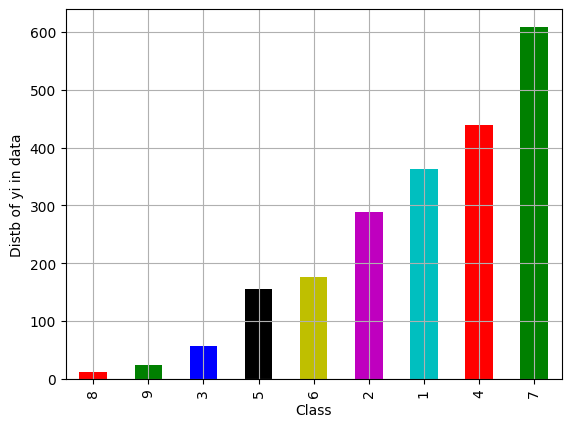

Number of data points in class 9 : 609 ( 28.672 %)
Number of data points in class 8 : 439 ( 20.669 %)
Number of data points in class 7 : 363 ( 17.09 %)
Number of data points in class 6 : 289 ( 13.606 %)
Number of data points in class 5 : 176 ( 8.286 %)
Number of data points in class 4 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 2 : 24 ( 1.13 %)
Number of data points in class 1 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


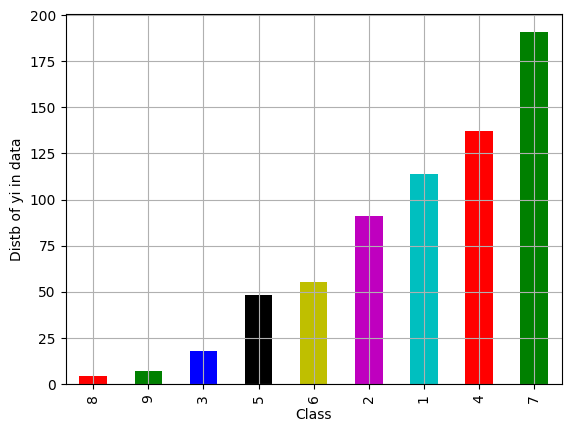

Number of data points in class 9 : 191 ( 28.722 %)
Number of data points in class 8 : 137 ( 20.602 %)
Number of data points in class 7 : 114 ( 17.143 %)
Number of data points in class 6 : 91 ( 13.684 %)
Number of data points in class 5 : 55 ( 8.271 %)
Number of data points in class 4 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 2 : 7 ( 1.053 %)
Number of data points in class 1 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


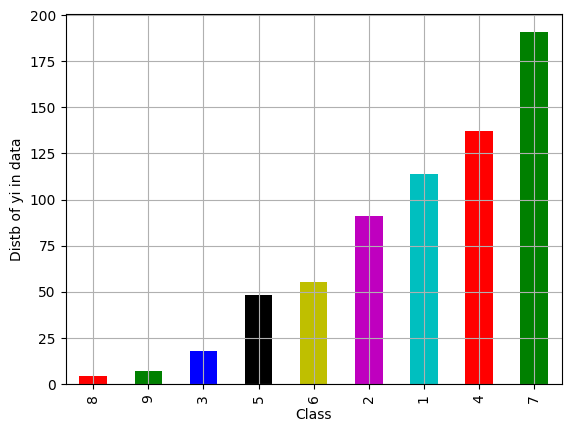

Number of data points in class 9 : 153 ( 28.759 %)
Number of data points in class 8 : 110 ( 20.677 %)
Number of data points in class 7 : 91 ( 17.105 %)
Number of data points in class 6 : 72 ( 13.534 %)
Number of data points in class 5 : 44 ( 8.271 %)
Number of data points in class 4 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 2 : 6 ( 1.128 %)
Number of data points in class 1 : 3 ( 0.564 %)


In [24]:
train_cls_distb=train_df['Class'].value_counts().sort_values()
test_cls_distb=test_df['Class'].value_counts().sort_values()
cv_cls_distb=cv_df['Class'].value_counts().sort_values()

my_colors=['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_cls_distb.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Distb of yi in data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_cls_distb.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_cls_distb.values[i], '(', np.round((train_cls_distb.values[i]/train_df.shape[0]*100), 3), '%)')

print('-'*80)
test_cls_distb.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Distb of yi in data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_cls_distb.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_cls_distb.values[i], '(', np.round((test_cls_distb.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
test_cls_distb.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Distb of yi in data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_cls_distb.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_cls_distb.values[i], '(', np.round((cv_cls_distb.values[i]/cv_df.shape[0]*100), 3), '%)')


#random model



In [25]:
def plot_confusion_matrix(test_y,predict_y):
  C=confusion_matrix(test_y,predict_y)
  A=(((C.T)/(C.sum(axis=1))).T)
  B =(C/C.sum(axis=0))

  labels=[1,2,3,4,5,6,7,8,9]


  print("-"*20, "Confusion matrix", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()



Log loss on Cross Validation Data using Random Model 2.529908724563923
Log loss on Test Data using Random Model 2.554611222633436
-------------------- Confusion matrix --------------------


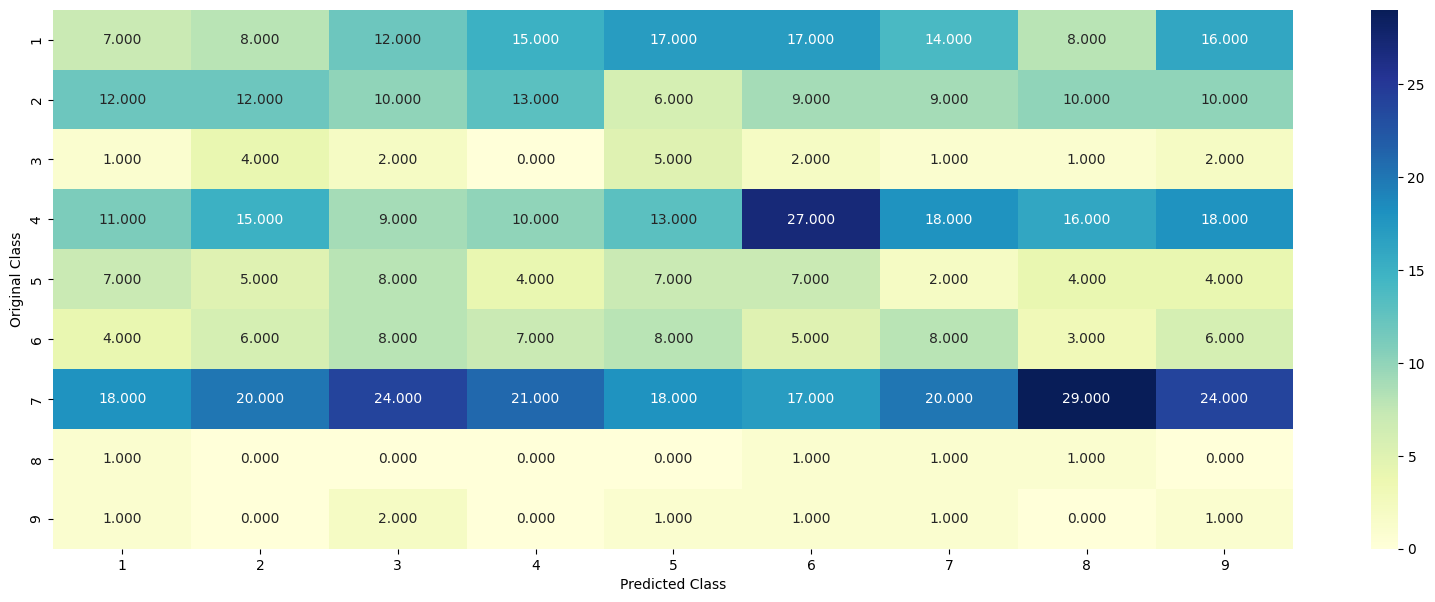

-------------------- Precision matrix (Columm Sum=1) --------------------


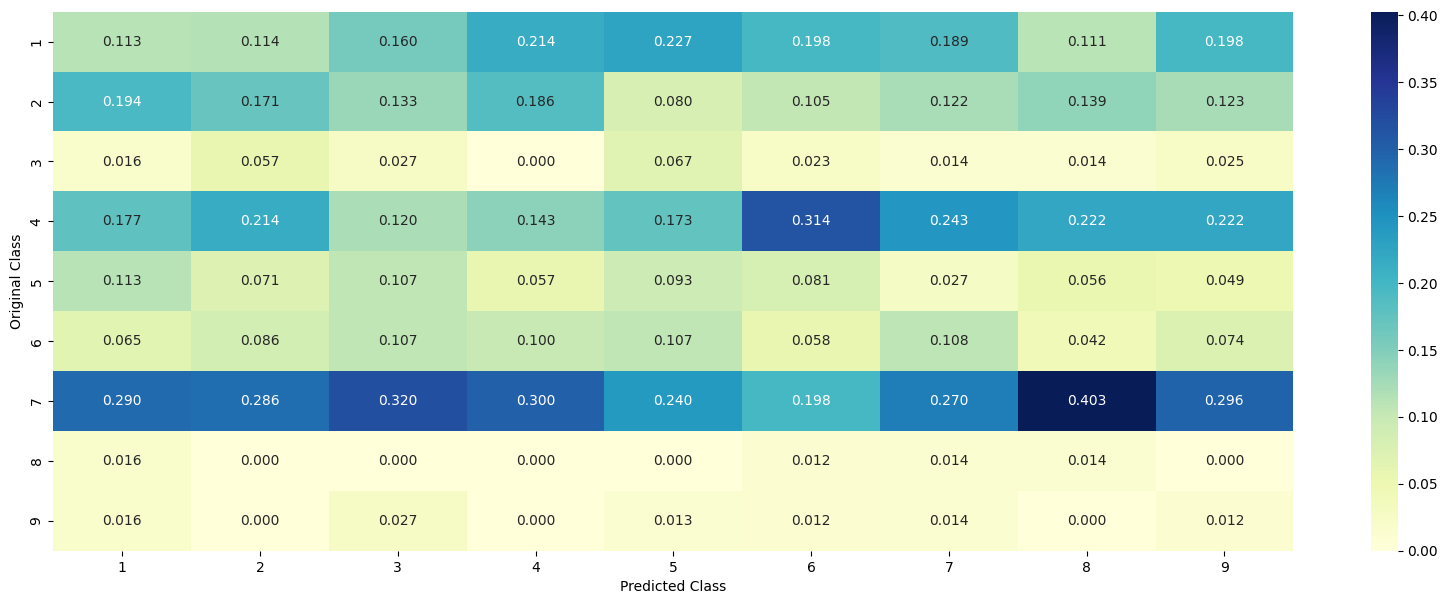

-------------------- Recall matrix (Row sum=1) --------------------


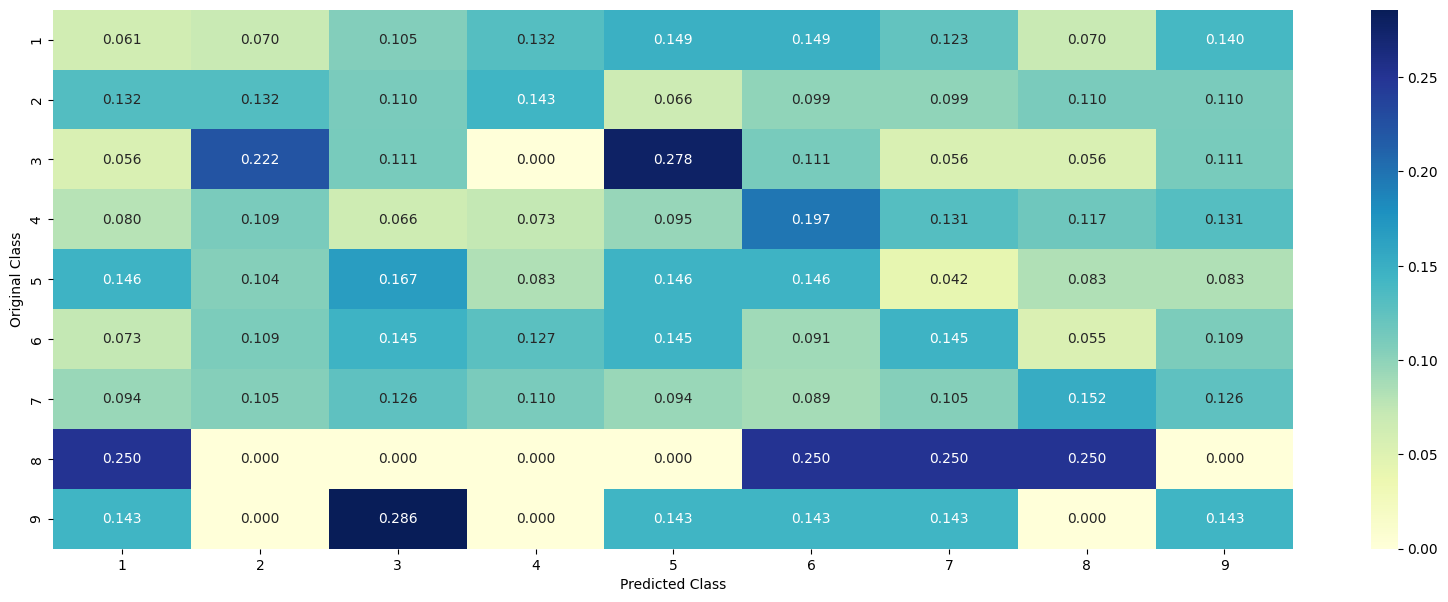

In [26]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [27]:
result.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variet...
1,1,CBL,W802*,2,abstract background non small cell lung cance...
2,2,CBL,Q249E,2,abstract background non small cell lung cance...
3,3,CBL,N454D,3,recent evidence demonstrated acquired unipare...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b linea...


# Univariate analysis

In [28]:
def get_gv_fea_dict(alpha, feature, df):
  value_count = train_df[feature].value_counts()
  gv_dict = dict()

  for i, denominator in value_count.items():
    vec=[]
    for k in range(1,10):
      cls_cnt=train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
      vec.append((cls_cnt.shape[0]+alpha*10)/(denominator+90*alpha))

      gv_dict[i]=vec

  return gv_dict

def get_gv_feature(alpha,feature,df):
  gv_dict=get_gv_fea_dict(alpha,feature,df)
  value_count=train_df[feature].value_counts()

  gv_fea=[]
  for index,row in df.iterrows():
    if row[feature] in dict(value_count).keys():
      gv_fea.append(gv_dict[row[feature]])
    else:
      gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])

  return gv_fea

In [29]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 222
BRCA1     175
TP53      108
EGFR       89
PTEN       81
BRCA2      75
BRAF       61
KIT        60
ALK        47
ERBB2      44
PDGFRA     41
Name: Gene, dtype: int64


In [30]:
print("There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

There are 222 different categories of genes in the train data, and they are distibuted as follows


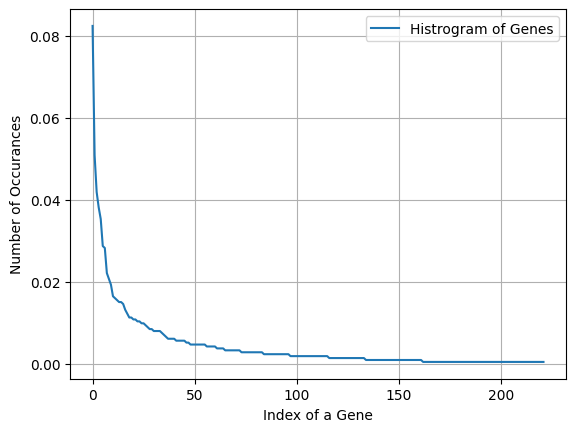

In [31]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


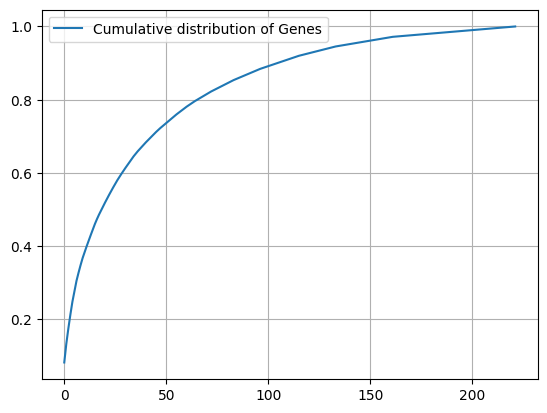

In [32]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [33]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [34]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [35]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [36]:
train_df['Gene'].head()

3059     FGF19
992       TSC1
1965    CTNNB1
1845     PPP6C
1754      IDH1
Name: Gene, dtype: object

In [37]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1a', 'arid2', 'arid5b', 'asxl1', 'atm', 'aurka',
       'axl', 'b2m', 'bap1', 'bard1', 'bcl10', 'bcor', 'braf', 'brca1',
       'brca2', 'brd4', 'brip1', 'btk', 'card11', 'carm1', 'casp8', 'cbl',
       'ccnd1', 'ccnd3', 'ccne1', 'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdk8',
       'cdkn1a', 'cdkn1b', 'cdkn2a', 'cdkn2b', 'cdkn2c', 'chek2', 'cic',
       'crebbp', 'ctcf', 'ctla4', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a',
       'dnmt3b', 'egfr', 'eif1ax', 'elf3', 'ep300', 'epas1', 'erbb2',
       'erbb3', 'erbb4', 'ercc2', 'ercc3', 'ercc4', 'erg', 'esr1', 'etv1',
       'etv6', 'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fat1', 'fbxw7',
       'fgf19', 'fgfr1', 'fgfr2', 'fgfr3', 'flt3', 'foxa1', 'foxl2',
       'foxp1', 'fubp1', 'gata3', 'gli1', 'gna11', 'gnas', 'h3f3a',
       'hist1h1c', 'hla', 'hnf1a', 'hras', 'idh1', 'idh2', 'igf1r',
       'ikbke', 'ikzf1', 'il7r', 'inpp4b', 'jak1', 'jak2', 'jun', 'kdm

In [38]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 222)


For values of alpha =  1e-05 The log loss is: 1.17692181001039
For values of alpha =  0.0001 The log loss is: 1.1427552716814189
For values of alpha =  0.001 The log loss is: 1.1940203716221633
For values of alpha =  0.01 The log loss is: 1.321606940860681
For values of alpha =  0.1 The log loss is: 1.43771971096652
For values of alpha =  1 The log loss is: 1.4813227005788896


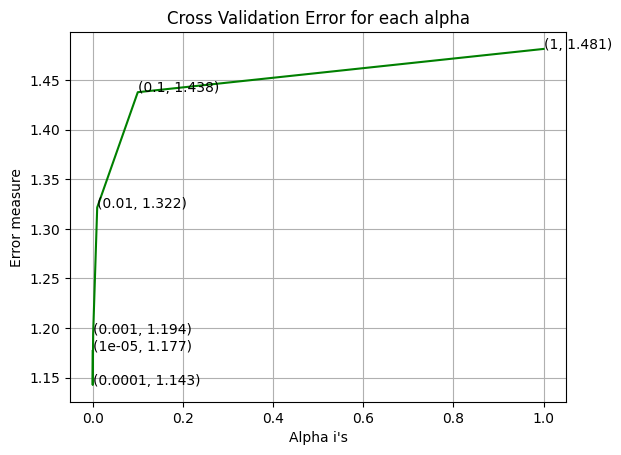

For values of best alpha =  0.0001 The train log loss is: 1.0134287103448956
For values of best alpha =  0.0001 The cross validation log loss is: 1.1427552716814189
For values of best alpha =  0.0001 The test log loss is: 1.1748529236424938


In [39]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [40]:
print("How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

How many data points in Test and CV datasets are covered by the  222  genes in train dataset?
Ans
1. In test data 634 out of 665 : 95.33834586466166
2. In cross validation data 508 out of  532 : 95.48872180451127


Analysis on variation feature

In [41]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1942
Truncating Mutations    53
Amplification           49
Deletion                43
Fusions                 22
G12V                     3
Q61R                     2
T73I                     2
E17K                     2
A146T                    2
C618R                    2
Name: Variation, dtype: int64


In [42]:
print("There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

There are 1942 different categories of variations in the train data, and they are distibuted as follows


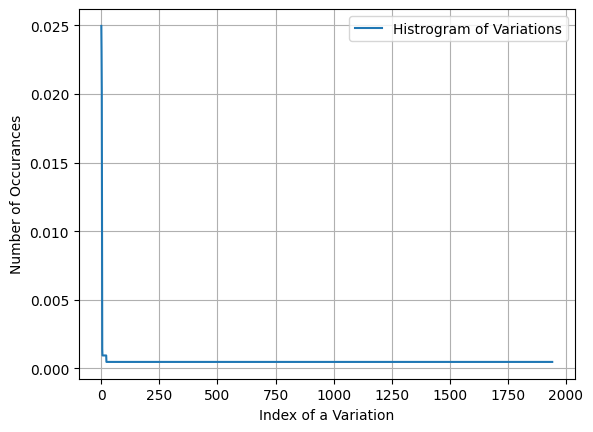

In [43]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02495292 0.0480226  0.06826742 ... 0.99905838 0.99952919 1.        ]


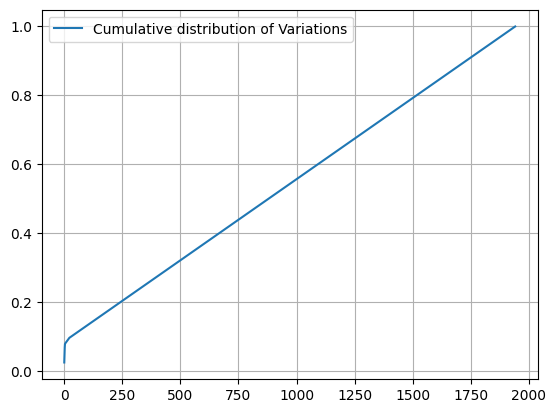

In [44]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [45]:
#alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [46]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [47]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [48]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1976)


Forvalues of alpha= 1e-05 the log loss is: 1.6945317319347462
Forvalues of alpha= 0.0001 the log loss is: 1.6848076449319436
Forvalues of alpha= 0.001 the log loss is: 1.6838846984477187
Forvalues of alpha= 0.01 the log loss is: 1.6942282377086884
Forvalues of alpha= 0.1 the log loss is: 1.7183055617855967
Forvalues of alpha= 1 the log loss is: 1.7211680212983527


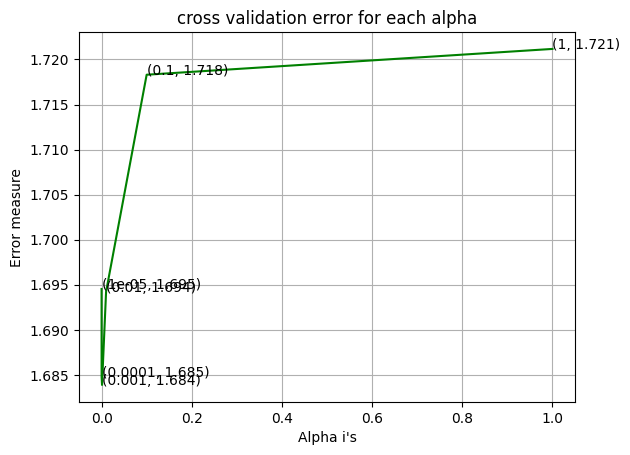

For values of best alpha =  0.001 The train log loss is: 1.2281869596302966
For values of best alpha =  0.001 The cross validation log loss is: 1.6838846984477187
For values of best alpha =  0.001 The test log loss is: 1.680680808302554


In [49]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
  clf=SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
  clf.fit(train_variation_feature_onehotCoding,y_train)

  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_variation_feature_onehotCoding,y_train)
  predict_y=sig_clf.predict_proba(cv_variation_feature_onehotCoding)

  cv_log_error_array.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
  print('Forvalues of alpha=',i,'the log loss is:',log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))

fig,ax=plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
 ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("cross validation error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha=np.argmin(cv_log_error_array)
clf=SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_variation_feature_onehotCoding,y_train)
sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding,y_train)

predict_y=sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [50]:
print("How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

How many data points are covered by total  1942  genes in test and cross validation data sets?

1. In test data 76 out of 665 : 11.428571428571429
2. In cross validation data 58 out of  532 : 10.902255639097744


In [51]:
def extract_dictionary_paddle(cls_text):
  dictionary=defaultdict(int)
  for index,row in cls_text.iterrows():
    for word in row['Text'].split():
      dictionary[word]+=1
  return dictionary

In [52]:
import math

In [53]:
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [54]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Text'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53437


In [55]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [56]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [57]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [58]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['Text'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['Text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [59]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [60]:
print(Counter(sorted_text_occur))

Counter({3: 5227, 4: 3934, 5: 2985, 6: 2395, 7: 2211, 8: 2113, 10: 1729, 9: 1607, 12: 1323, 11: 1186, 15: 933, 16: 886, 14: 835, 13: 826, 18: 668, 20: 630, 17: 614, 21: 595, 24: 546, 19: 514, 22: 441, 36: 436, 26: 401, 23: 395, 28: 373, 25: 363, 30: 351, 27: 340, 33: 304, 32: 291, 52: 283, 29: 280, 34: 264, 40: 261, 31: 235, 35: 228, 42: 219, 46: 195, 37: 194, 39: 191, 38: 191, 41: 187, 48: 173, 43: 173, 44: 169, 51: 165, 45: 161, 47: 158, 53: 149, 54: 146, 50: 146, 49: 146, 56: 144, 55: 135, 57: 132, 58: 131, 66: 122, 64: 119, 60: 118, 61: 113, 63: 111, 70: 108, 72: 105, 67: 105, 68: 102, 76: 101, 73: 101, 59: 101, 62: 99, 71: 95, 80: 93, 92: 89, 65: 89, 69: 86, 81: 83, 96: 81, 74: 81, 85: 77, 88: 76, 84: 75, 79: 73, 78: 73, 90: 72, 77: 69, 95: 67, 87: 67, 75: 67, 104: 66, 93: 66, 105: 65, 82: 63, 83: 62, 89: 60, 110: 59, 86: 59, 94: 58, 91: 58, 107: 57, 98: 55, 97: 54, 113: 53, 99: 53, 130: 52, 126: 52, 102: 52, 100: 52, 108: 51, 138: 50, 123: 50, 109: 49, 111: 48, 103: 48, 106: 47, 

For values of alpha =  1e-05 The log loss is: 1.2775803293037187
For values of alpha =  0.0001 The log loss is: 1.1209025646295514
For values of alpha =  0.001 The log loss is: 1.10475444884881
For values of alpha =  0.01 The log loss is: 1.1804722424224194
For values of alpha =  0.1 The log loss is: 1.4225496741546197
For values of alpha =  1 The log loss is: 1.6507415691890666


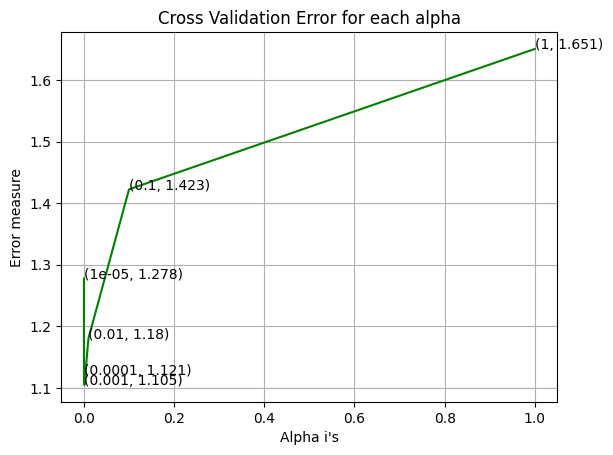

For values of best alpha =  0.001 The train log loss is: 0.6421830906939684
For values of best alpha =  0.001 The cross validation log loss is: 1.10475444884881
For values of best alpha =  0.001 The test log loss is: 1.1764767557236053


In [61]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [62]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [63]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.637 % of word of test data appeared in train data
98.544 % of word of Cross Validation appeared in train data


# Machine learning models

In [64]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [65]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [66]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text'])

    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())

    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [67]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [68]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross valalidation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55635)
(number of data points * number of features) in test data =  (665, 55635)
(number of data points * number of features) in cross valalidation data = (532, 55635)


In [69]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [70]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


#Naive bayes

for alpha = 1e-05
Log Loss : 1.2562938162931394
for alpha = 0.0001
Log Loss : 1.2539147846410512
for alpha = 0.001
Log Loss : 1.2505148217951112
for alpha = 0.1
Log Loss : 1.254192104416087
for alpha = 1
Log Loss : 1.2694236698460317
for alpha = 10
Log Loss : 1.3637221620612447
for alpha = 100
Log Loss : 1.3273946620746777
for alpha = 1000
Log Loss : 1.242884689037898


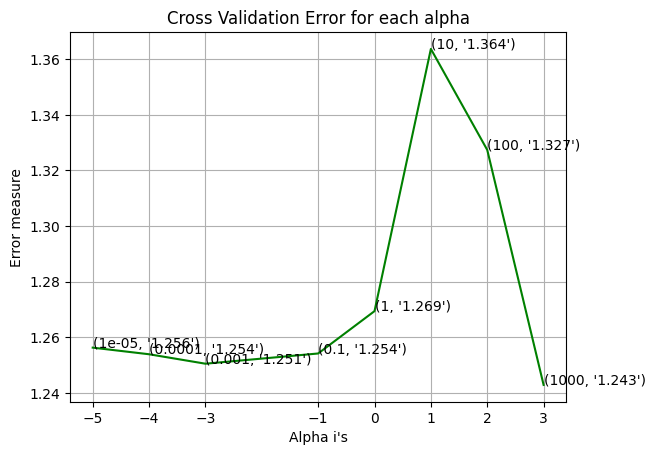

For values of best alpha =  1000 The train log loss is: 1.045485043958888
For values of best alpha =  1000 The cross validation log loss is: 1.242884689037898
For values of best alpha =  1000 The test log loss is: 1.2973179244879787


In [71]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.242884689037898
Number of missclassified point : 0.4323308270676692
-------------------- Confusion matrix --------------------


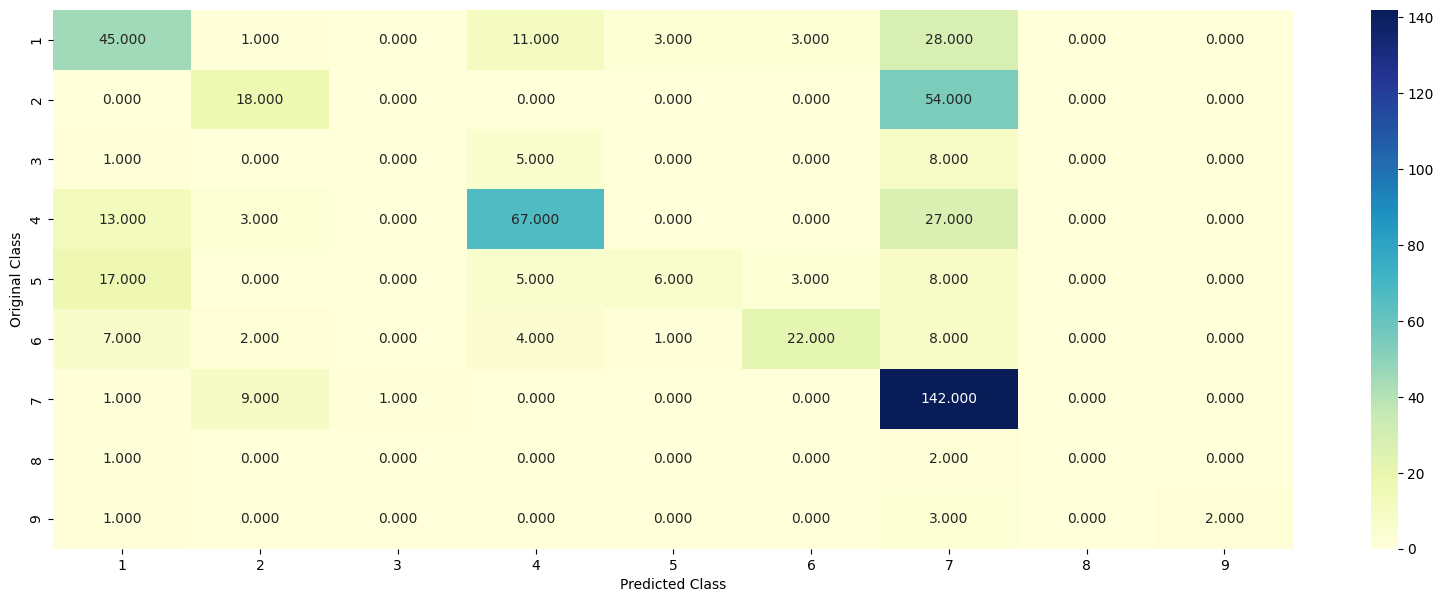

-------------------- Precision matrix (Columm Sum=1) --------------------


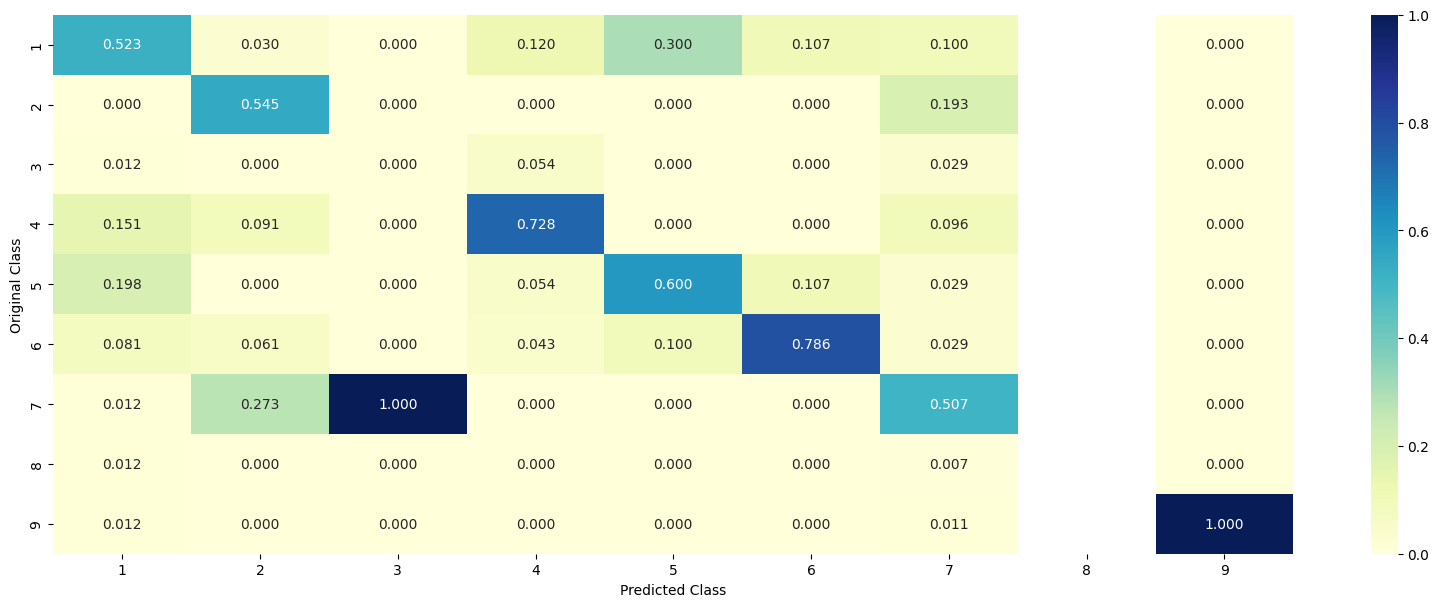

-------------------- Recall matrix (Row sum=1) --------------------


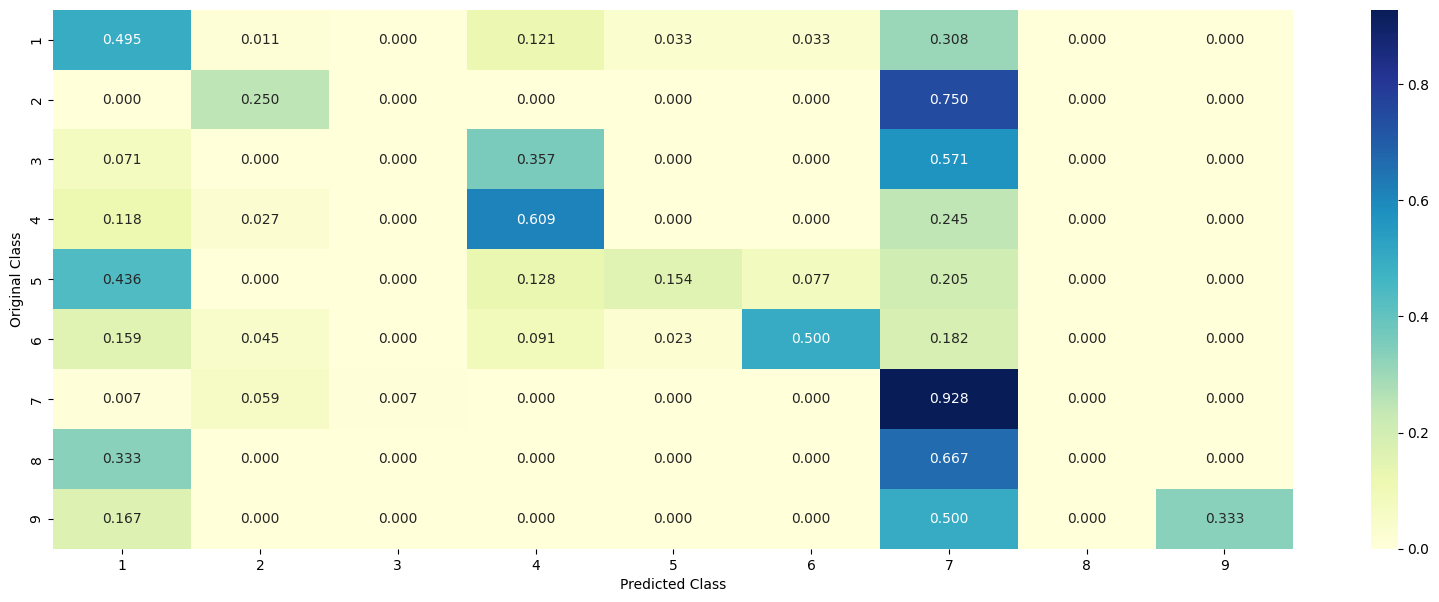

In [72]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [73]:
test_point_index = 5
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0784 0.1067 0.0063 0.0628 0.0212 0.0158 0.7017 0.0056 0.0015]]
Actual Class : 7
--------------------------------------------------
19 Text feature [kinase] present in test data point [True]
20 Text feature [presence] present in test data point [True]
21 Text feature [activating] present in test data point [True]
22 Text feature [inhibitor] present in test data point [True]
23 Text feature [expressing] present in test data point [True]
24 Text feature [well] present in test data point [True]
25 Text feature [recently] present in test data point [True]
26 Text feature [showed] present in test data point [True]
27 Text feature [independent] present in test data point [True]
28 Text feature [contrast] present in test data point [True]
30 Text feature [previously] present in test data point [True]
31 Text feature [shown] present in test data point [True]
32 Text feature [cells] present in test data point [True]
33 Text feature [obtained

In [74]:
test_df['Text'].iloc[test_point_index]

' germline pdgfra mutations cause multiple heterogeneous gastrointestinal mesenchymal tumors familial form disease formerly termed intestinal neurofibromatosis neurofibromatosis 3b inf nf3b included among familial gastrointestinal stromal tumors gists genotype described gist known pdgfra mutant gastrointestinal tumor shortly afterwards however inflammatory fibroid polyps also revealed pdgfra mutations subsequently gastrointestinal cd34 fibrous tumors uncertain classification described germline pdgfra mutant context aim characterize syndrome produced germline pdgfra mutations establish diagnostic criteria management strategies hitherto puzzling disease studied kindred displaying multiple gastrointestinal mesenchymal tumors comparing published families individuals possible analogous conditions identified novel inherited pdgfra mutation p653l constituting third reported example familial pdgfra mutation adult mutants detected inflammatory fibroid polyps gastric gists gastrointestinal fibro

In [75]:
no_feature

100

In [76]:
test_df['Gene'].iloc[test_point_index]

'PDGFRA'

In [77]:
test_df['Variation'].iloc[test_point_index]

'Y555C'

In [78]:
clf.feature_log_prob_.shape

(9, 55635)

In [79]:
indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
indices[0]

array([27817, 40726, 40729, 40733, 40741, 40747, 15181, 40721, 40754,
       40757, 40766, 15165, 40767, 40768, 40777, 40756, 15154, 40711,
       15199, 15229, 40664, 15225, 15220, 15219, 40675, 15197, 15217,
       40678, 40694, 15210, 15207, 40703, 40704, 15214, 40663, 15153,
       40780, 15101, 40858, 40866, 40867, 40869, 40870, 40852, 15085,
       40871, 40875, 15078, 15077, 15076, 15075, 15084, 15152, 40848,
       40841, 40782, 15146, 40785, 15143, 40791, 15137, 40842, 15132,
       15124, 40821, 40827, 40831, 15112, 40835, 15127, 15072, 40655,
       40628, 40556, 40557, 40558, 15321, 15319, 40562, 40551, 40566,
       15313, 40573, 15308, 40579, 40580, 40581, 40570, 40582, 40550,
       40549, 40530, 15355, 15354, 15353, 40531, 15351, 15333, 40534,
       15345])

In [80]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text'])

    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())

    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [81]:
for i in range(10):
  test_point_index = i
  no_feature = 100
  predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
  print("Predicted Class :", predicted_cls[0])
  print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
  print("Actual Class :", test_y[test_point_index])
  indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
  print("-"*50)
  get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index].lower(),test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[4.434e-01 3.415e-01 1.800e-03 1.508e-01 5.100e-03 2.800e-03 5.050e-02
  3.800e-03 3.000e-04]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 4
Predicted Class Probabilities: [[0.0259 0.0138 0.0068 0.8559 0.0212 0.0159 0.0542 0.0046 0.0017]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 7
Predicted Class Probabilities: [[0.0866 0.1892 0.0319 0.1082 0.0676 0.0787 0.415  0.0097 0.0131]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 7
Predicted Class Probabilities: [[0.000e+00 3.300e-03 2.000e-04 0.000e+00 0.000e+00 0.000e+00 9.926e-01
  3.900e-03 0.000e+00]]
Actual Class : 7
--------------------------------------------------
Out of the top  10

# KNN

for alpha = 5
Log Loss : 0.9837397158959315
for alpha = 11
Log Loss : 0.9881531603483139
for alpha = 15
Log Loss : 1.0033784143547186
for alpha = 21
Log Loss : 1.0130788955365526
for alpha = 31
Log Loss : 1.0287968955077025
for alpha = 41
Log Loss : 1.0373176856808557
for alpha = 51
Log Loss : 1.0415259112533293
for alpha = 99
Log Loss : 1.0477713531005048


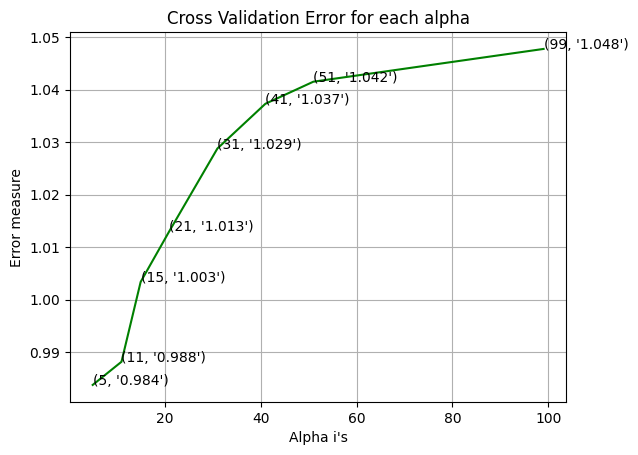

For values of best alpha =  5 The train log loss is: 0.4606764371358586
For values of best alpha =  5 The cross validation log loss is: 0.9837397158959315
For values of best alpha =  5 The test log loss is: 1.0156625290608219


In [82]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.9837397158959315
Number of mis-classified points : 0.3308270676691729
-------------------- Confusion matrix --------------------


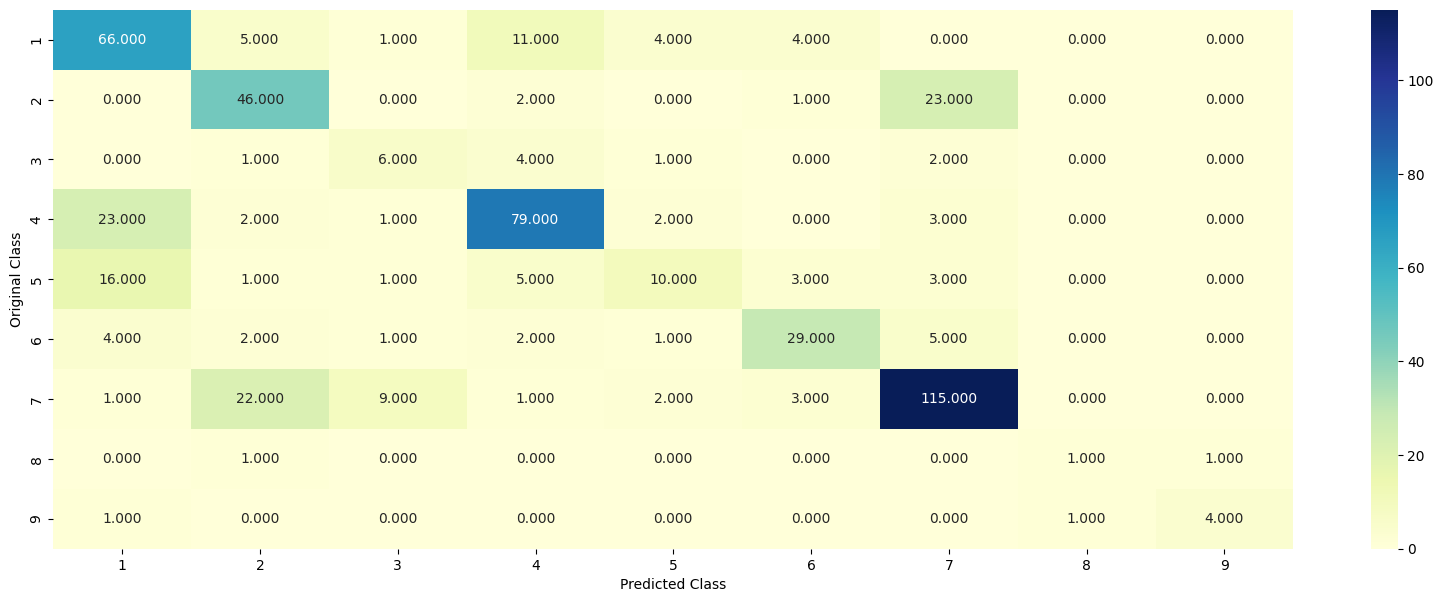

-------------------- Precision matrix (Columm Sum=1) --------------------


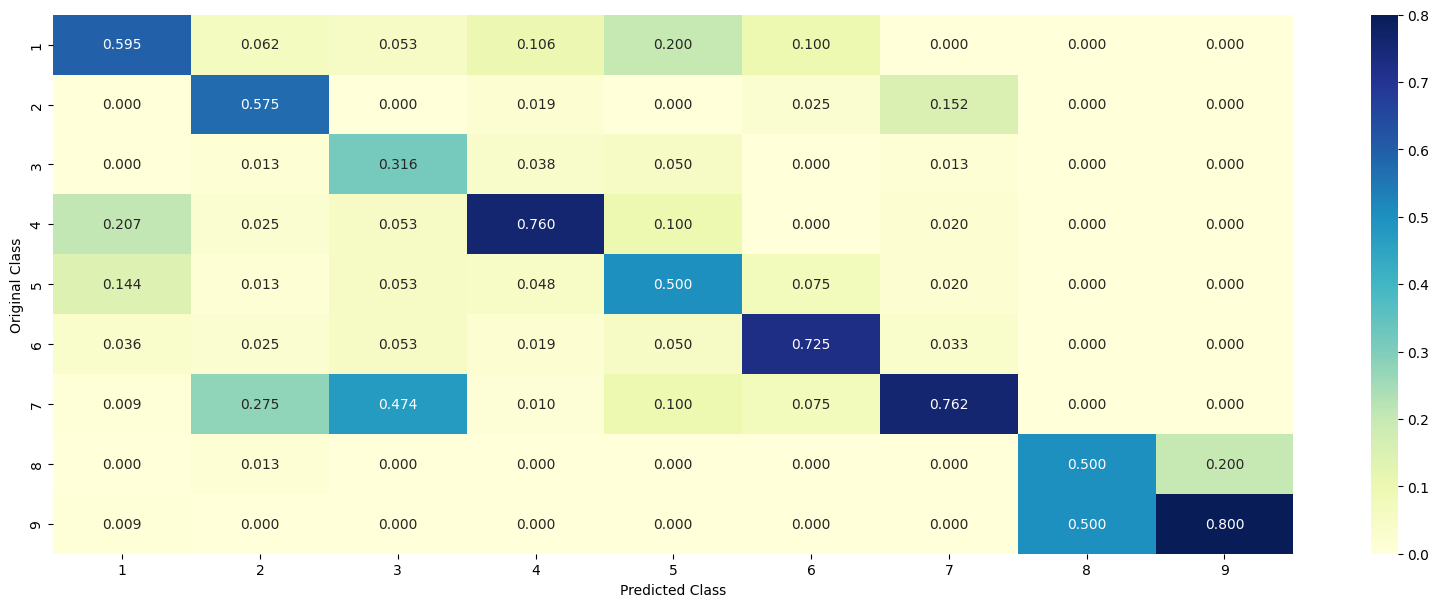

-------------------- Recall matrix (Row sum=1) --------------------


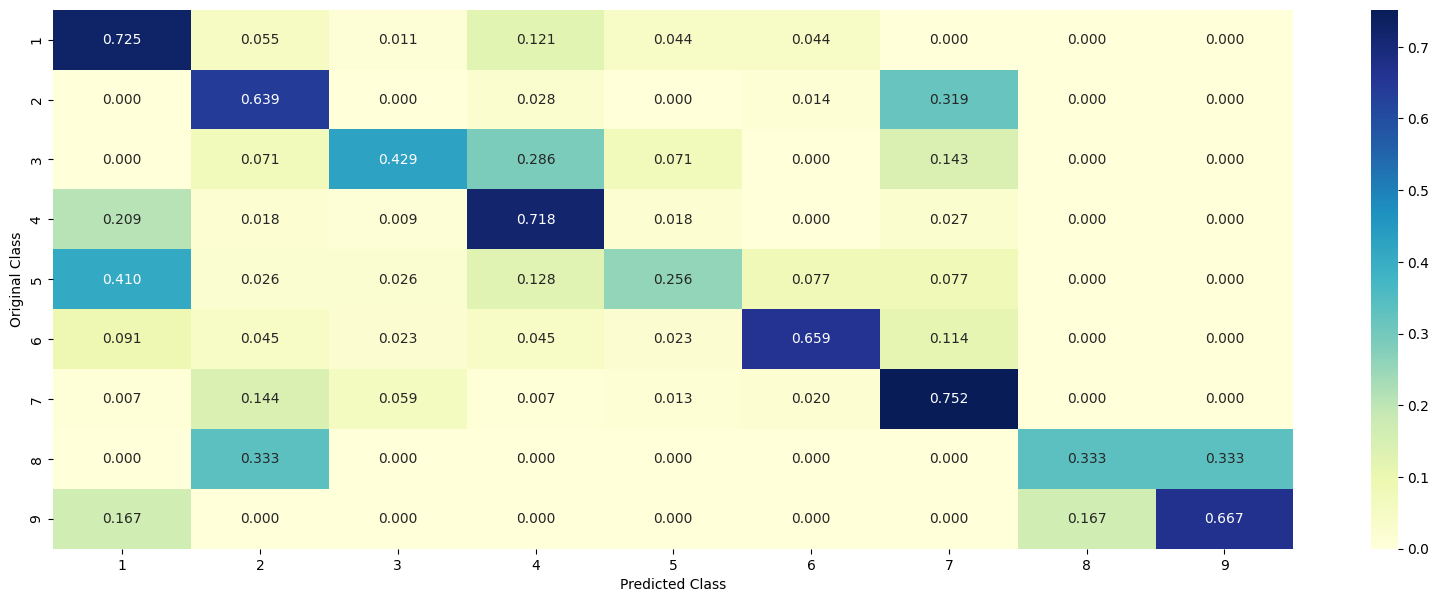

In [83]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

Sample query point

In [84]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 4
The  5  nearest neighbours of the test points belongs to classes [4 4 4 4 4]
Fequency of nearest points : Counter({4: 5})


Sample query point 2

In [85]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 2
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [2 2 2 7 2]
Fequency of nearest points : Counter({2: 4, 7: 1})


#logistic regression

with class balancing

for alpha = 1e-06
Log Loss : 1.2644321105679823
for alpha = 1e-05
Log Loss : 1.219110214239363
for alpha = 0.0001
Log Loss : 1.0463149350292824
for alpha = 0.001
Log Loss : 1.0262252624329256
for alpha = 0.01
Log Loss : 1.0650067389679836
for alpha = 0.1
Log Loss : 1.4016951353892453
for alpha = 1
Log Loss : 1.653196579362479
for alpha = 10
Log Loss : 1.684880507147685
for alpha = 100
Log Loss : 1.688227436499475


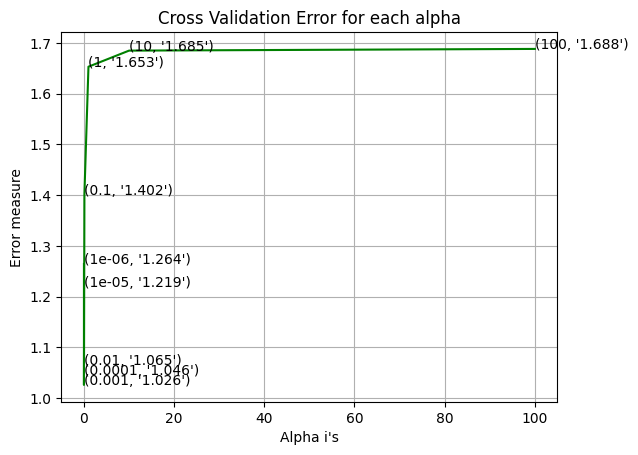

For values of best alpha =  0.001 The train log loss is: 0.5147677960021114
For values of best alpha =  0.001 The cross validation log loss is: 1.0262252624329256
For values of best alpha =  0.001 The test log loss is: 1.0647139005175248


In [86]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0262252624329256
Number of mis-classified points : 0.33646616541353386
-------------------- Confusion matrix --------------------


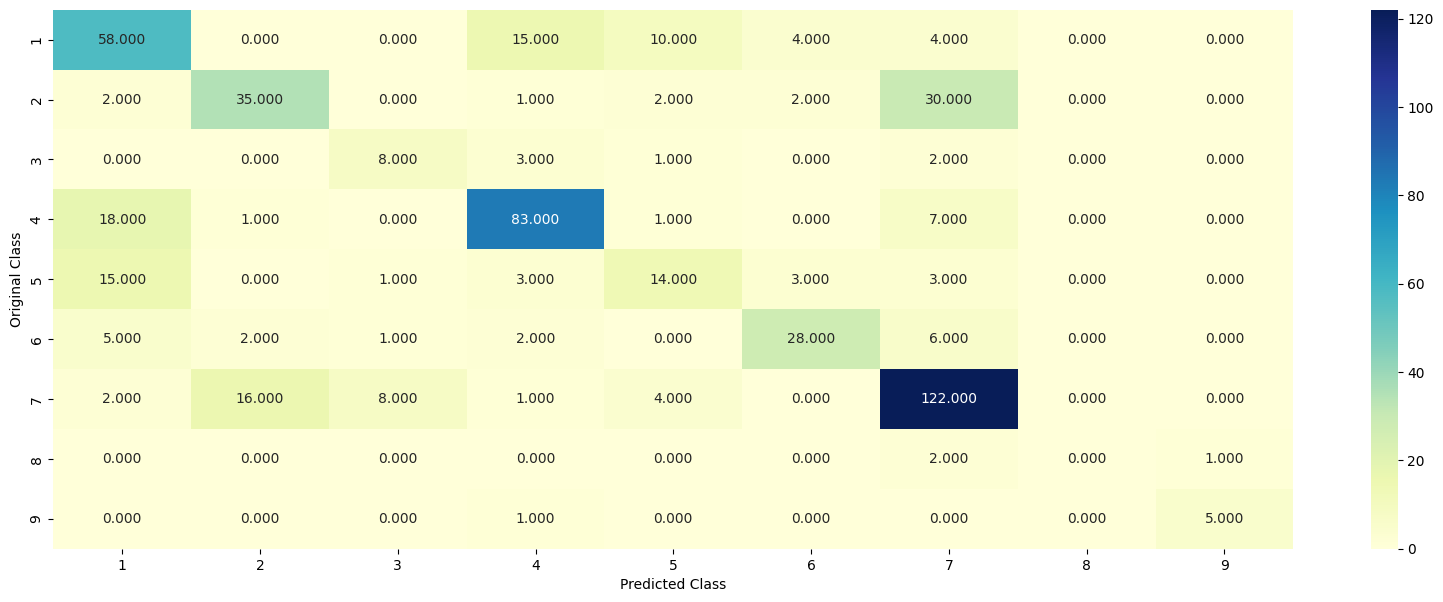

-------------------- Precision matrix (Columm Sum=1) --------------------


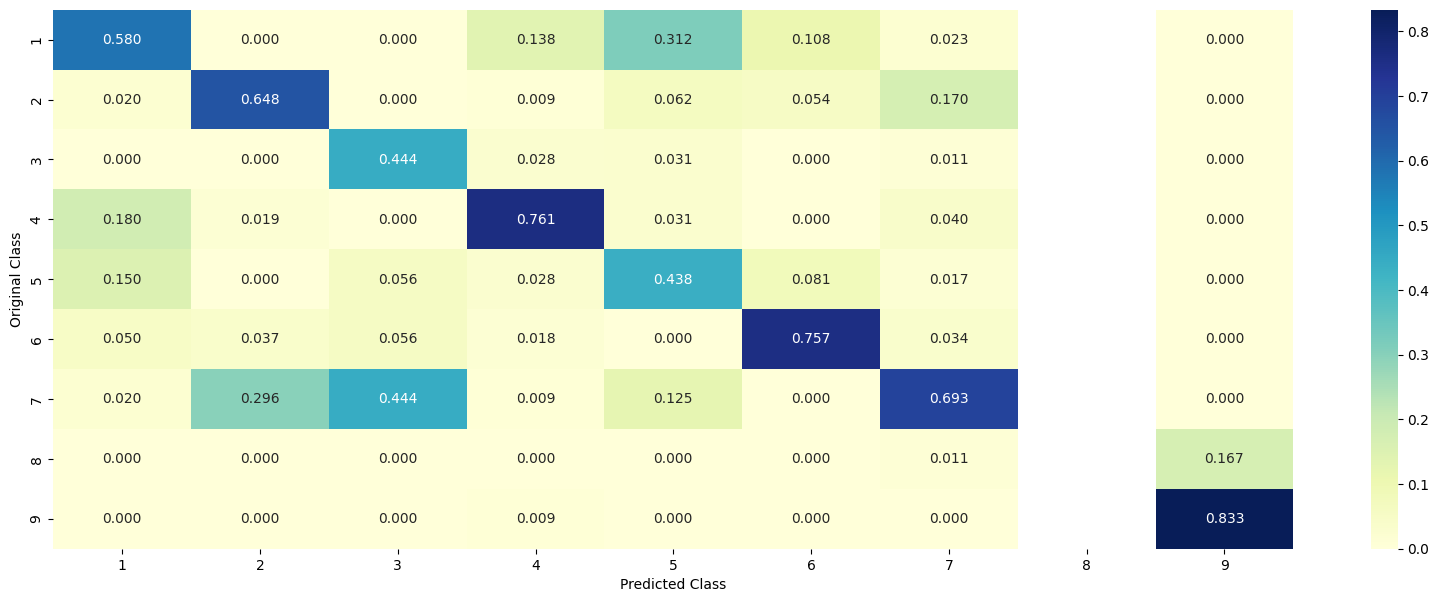

-------------------- Recall matrix (Row sum=1) --------------------


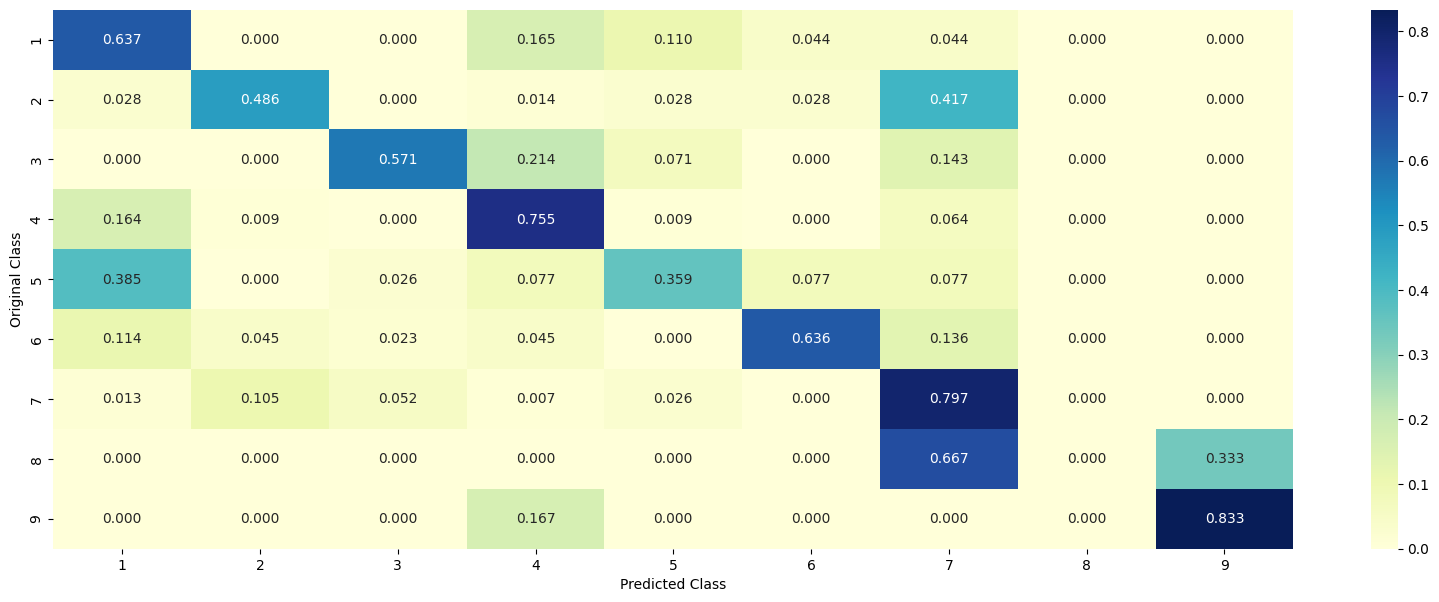

In [87]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [88]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [89]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0107 0.0141 0.0039 0.9417 0.0101 0.0058 0.0085 0.0029 0.0023]]
Actual Class : 4
--------------------------------------------------
312 Text feature [mislocalized] present in test data point [True]
353 Text feature [behaved] present in test data point [True]
430 Text feature [novel] present in test data point [True]
487 Text feature [yeast] present in test data point [True]
Out of the top  500  features  4 are present in query point


In [90]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.023  0.8174 0.0075 0.018  0.0194 0.0175 0.088  0.0045 0.0047]]
Actual Class : 2
--------------------------------------------------
443 Text feature [missense] present in test data point [True]
471 Text feature [chemoradiotherapy] present in test data point [True]
Out of the top  500  features  2 are present in query point


Without class balancing

for alpha = 1e-06
Log Loss : 1.2520393481589436
for alpha = 1e-05
Log Loss : 1.2309226306896528
for alpha = 0.0001
Log Loss : 1.0584331416938035
for alpha = 0.001
Log Loss : 1.0258139937578243
for alpha = 0.01
Log Loss : 1.0921544914933397
for alpha = 0.1
Log Loss : 1.3159743757872355
for alpha = 1
Log Loss : 1.5884026393273643


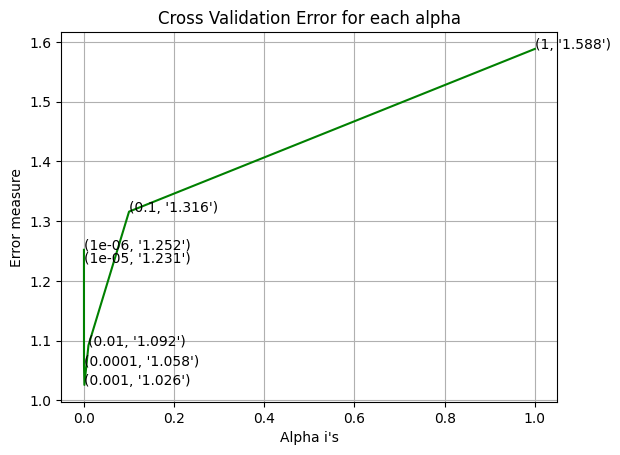

For values of best alpha =  0.001 The train log loss is: 0.513902072348977
For values of best alpha =  0.001 The cross validation log loss is: 1.0258139937578243
For values of best alpha =  0.001 The test log loss is: 1.0670504587959935


In [91]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0258139937578243
Number of mis-classified points : 0.3308270676691729
-------------------- Confusion matrix --------------------


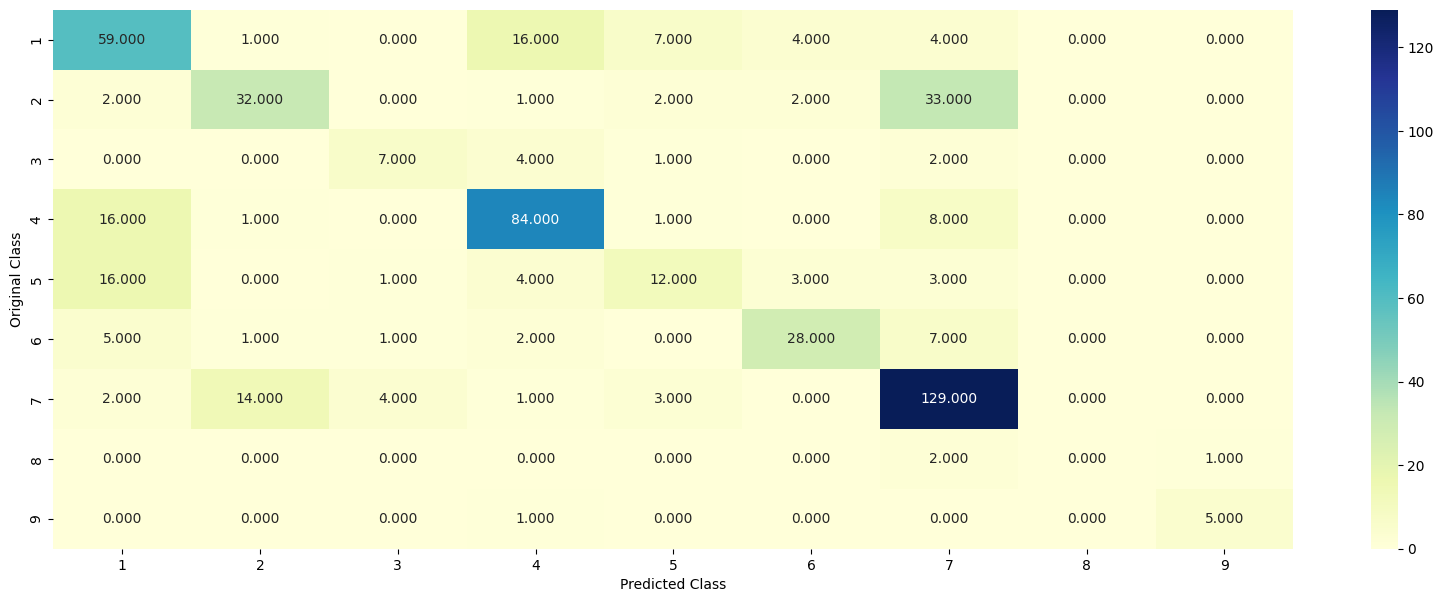

-------------------- Precision matrix (Columm Sum=1) --------------------


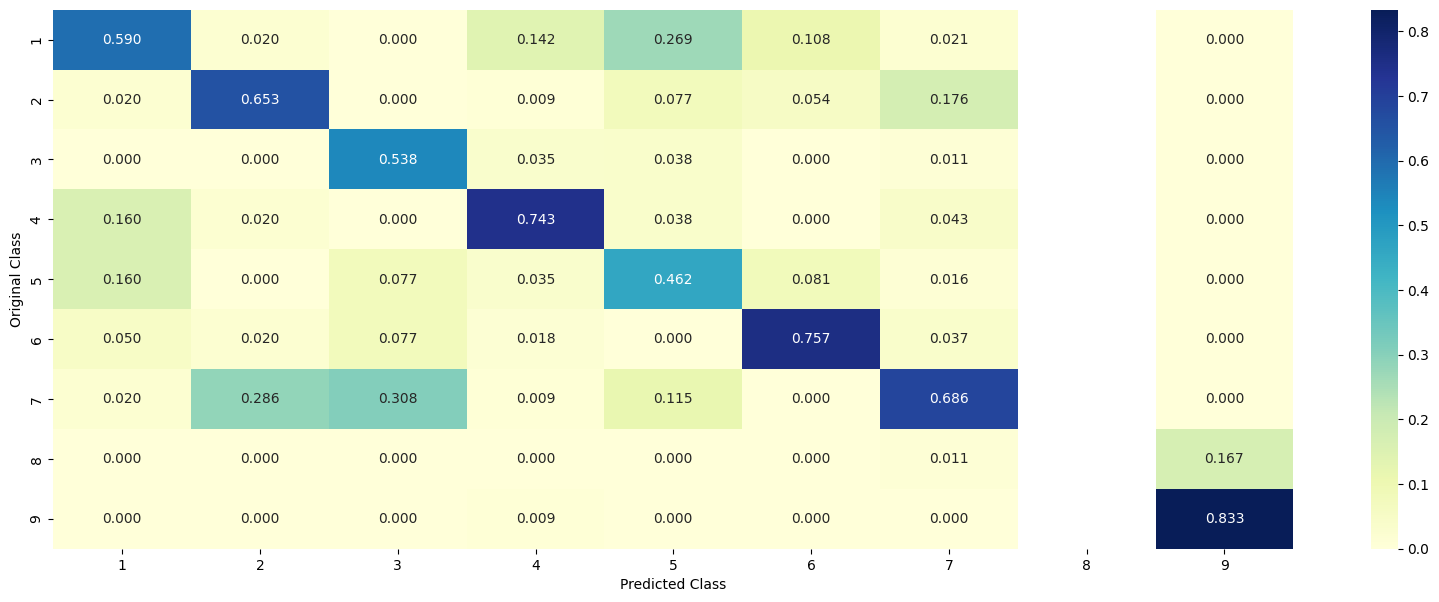

-------------------- Recall matrix (Row sum=1) --------------------


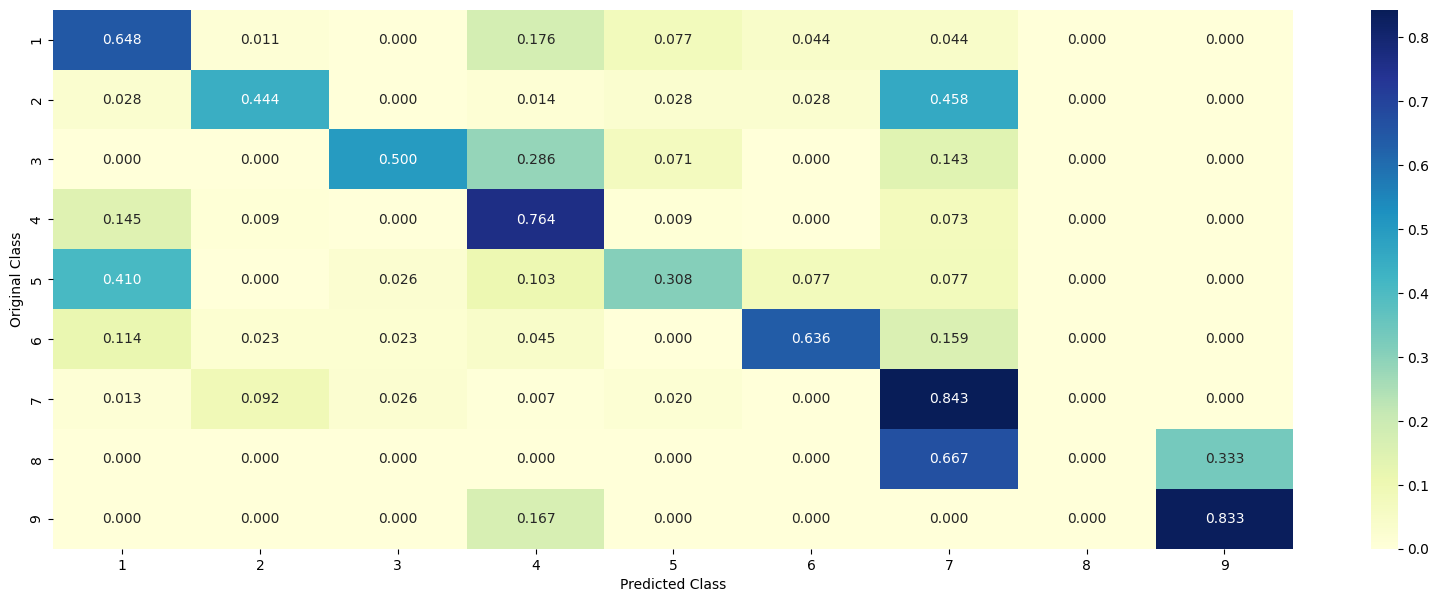

In [92]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [93]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[1.130e-02 1.470e-02 3.800e-03 9.405e-01 9.600e-03 5.600e-03 1.140e-02
  2.300e-03 9.000e-04]]
Actual Class : 4
--------------------------------------------------
434 Text feature [mislocalized] present in test data point [True]
456 Text feature [behaved] present in test data point [True]
Out of the top  500  features  2 are present in query point


In [94]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0227 0.8259 0.0081 0.0178 0.0197 0.0176 0.081  0.004  0.0031]]
Actual Class : 2
--------------------------------------------------
Out of the top  500  features  0 are present in query point


#Leniar SVM

for C= 1e-05
log loss: 1.2388564478889177
for C= 0.0001
log loss: 1.1807071915832856
for C= 0.001
log loss: 1.1037747984750945
for C= 0.01
log loss: 1.1360775444245392
for C= 0.1
log loss: 1.3160469076773518
for C= 1
log loss: 1.6712496103061083
for C= 10
log loss: 1.6887716312137688
for C= 100
log loss: 1.6887716037627856


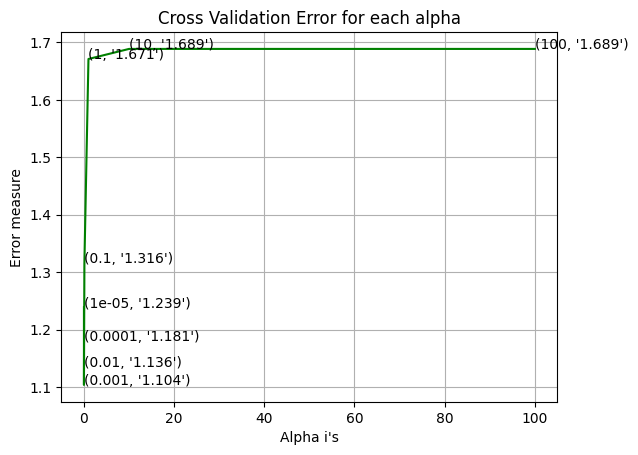

For values of best alpha=  0.001 The train log loss is: 1.6643612228926012
For values of best alpha =  0.001 The cross validation log loss is: 1.688771646087218
For values of best alpha =  0.001 The test log loss is: 1.7155105246891709


In [95]:
alpha=[10**x for x in range(-5,3)]
cv_log_error_array=[]

for i in alpha:
  print("for C=", i)
  clf=SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='hinge',random_state=42)
  clf.fit(train_x_onehotCoding,train_y)
  sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
  sig_clf.fit(train_x_onehotCoding,train_y)
  sig_clf_probs=sig_clf.predict_proba(cv_x_onehotCoding)
  cv_log_error_array.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
  print("log loss:",log_loss(cv_y,sig_clf_probs))

fig,ax=plt.subplots()
ax.plot(alpha,cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
  ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha=np.argmin(cv_log_error_array)
clf=SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='hinge',random_state=42)
clf.fit(train_x_onehotCoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(train_x_onehotCoding,train_y)

predict_y=sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha= ',alpha[best_alpha],"The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.1037747984750945
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


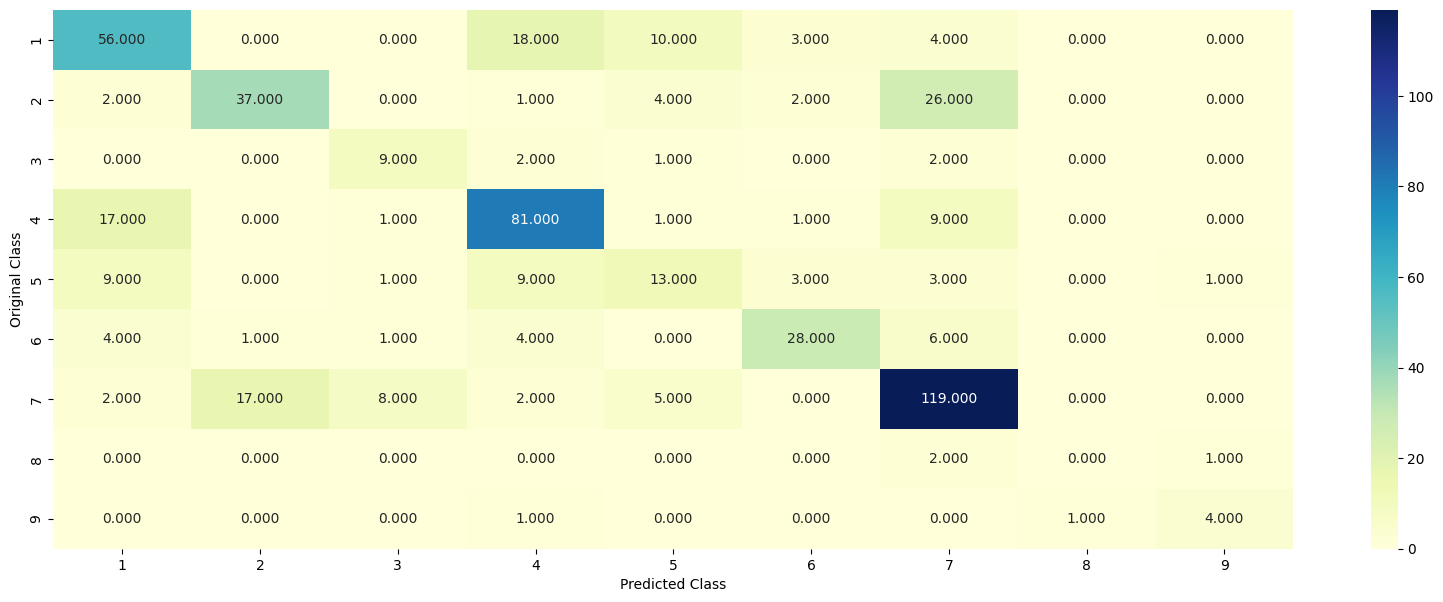

-------------------- Precision matrix (Columm Sum=1) --------------------


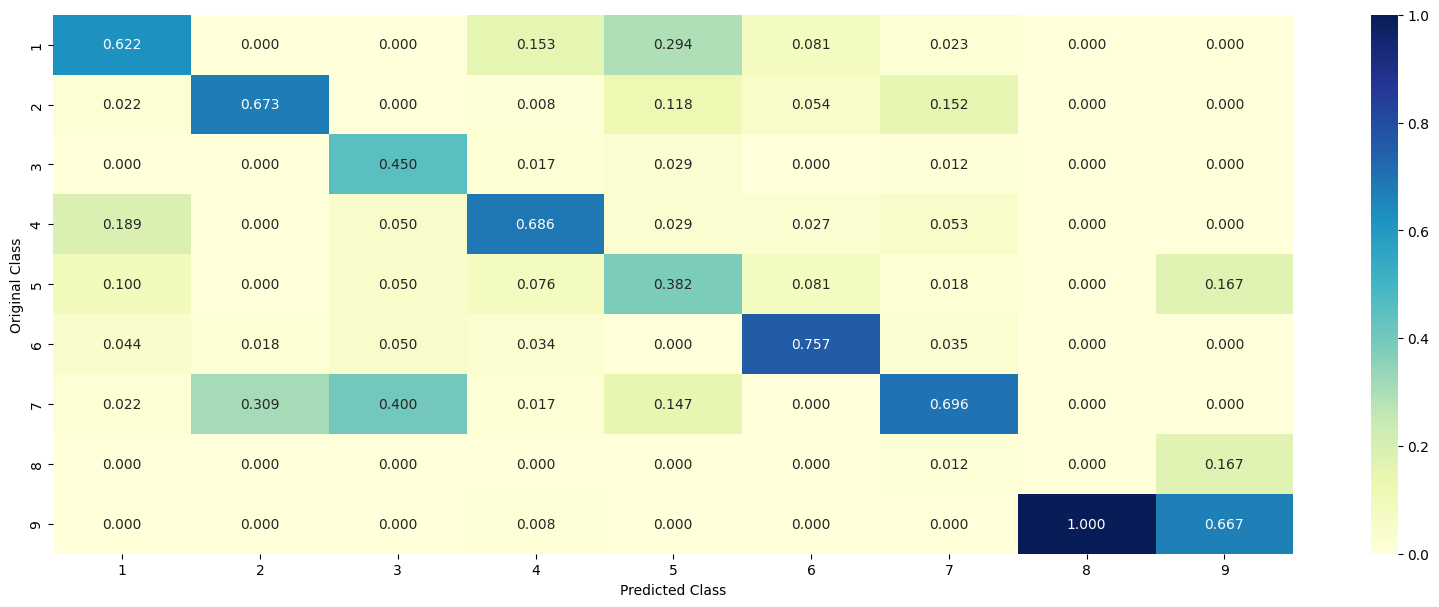

-------------------- Recall matrix (Row sum=1) --------------------


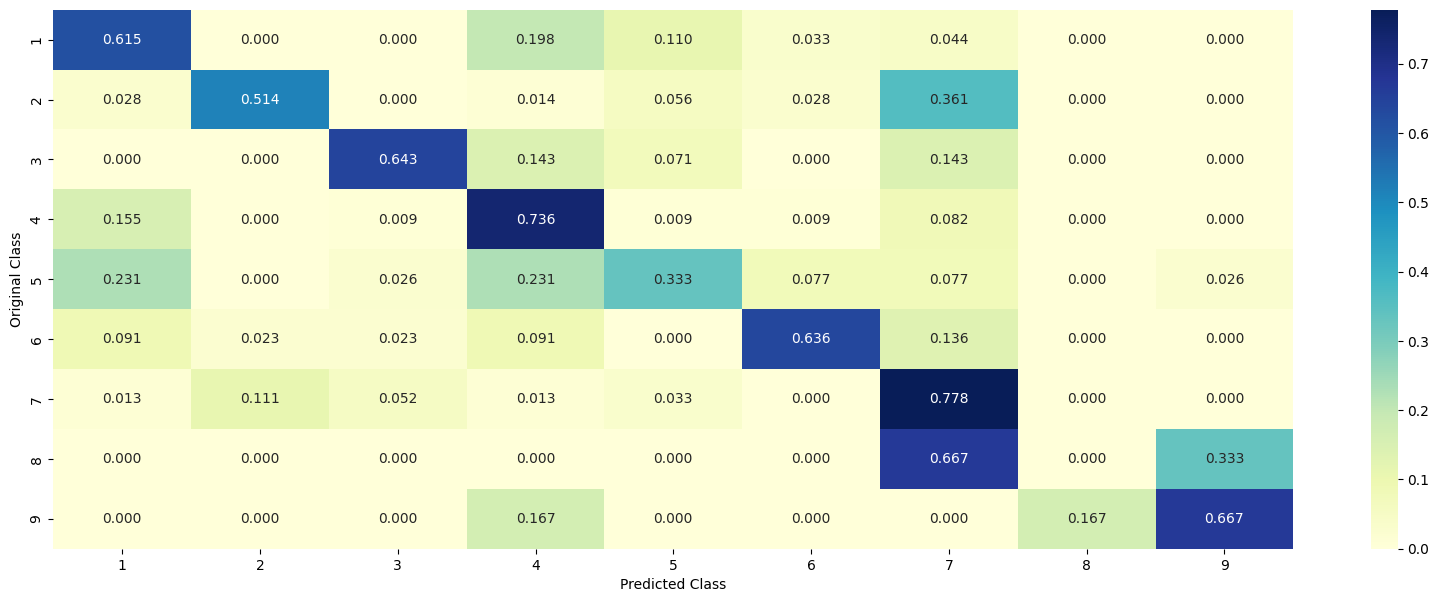

In [96]:
clf=SGDClassifier(alpha=alpha[best_alpha],penalty="l2",loss='hinge',random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding,train_y,cv_x_onehotCoding,cv_y,clf)

##Feature Importance

In [97]:
clf=SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss="hinge",random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index=1
no_feature=500
predicted_cls=sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:",predicted_cls[0])
print("predicted class probabilities",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)



Predicted Class: 7
predicted class probabilities [[0.1724 0.1391 0.0142 0.279  0.0545 0.0392 0.2937 0.0049 0.0031]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


In [98]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1708 0.1504 0.0233 0.2011 0.0714 0.0733 0.2966 0.006  0.0072]]
Actual Class : 2
--------------------------------------------------
Out of the top  500  features  0 are present in query point


#Random forrest

for n_estimators = 100 and max depth =  5
Log Loss : 1.2486569916439005
for n_estimators = 100 and max depth =  10
Log Loss : 1.1709155830600468
for n_estimators = 200 and max depth =  5
Log Loss : 1.2407280594446752
for n_estimators = 200 and max depth =  10
Log Loss : 1.1622741923720536
for n_estimators = 500 and max depth =  5
Log Loss : 1.2371419014955283
for n_estimators = 500 and max depth =  10
Log Loss : 1.1568147980959136
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2338579813311001
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1546795987948755
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2321558675184727
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1547889665338353


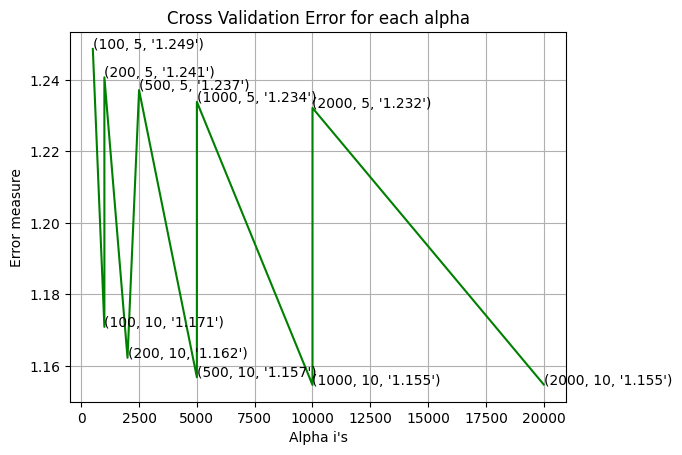

For values of best estimator =  1000 The train log loss is: 0.6972509464293202
For values of best estimator =  1000 The cross validation log loss is: 1.1546795987948755
For values of best estimator =  1000 The test log loss is: 1.138406507661476


In [99]:
from sklearn.ensemble import RandomForestClassifier
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1546795987948753
Number of mis-classified points : 0.38345864661654133
-------------------- Confusion matrix --------------------


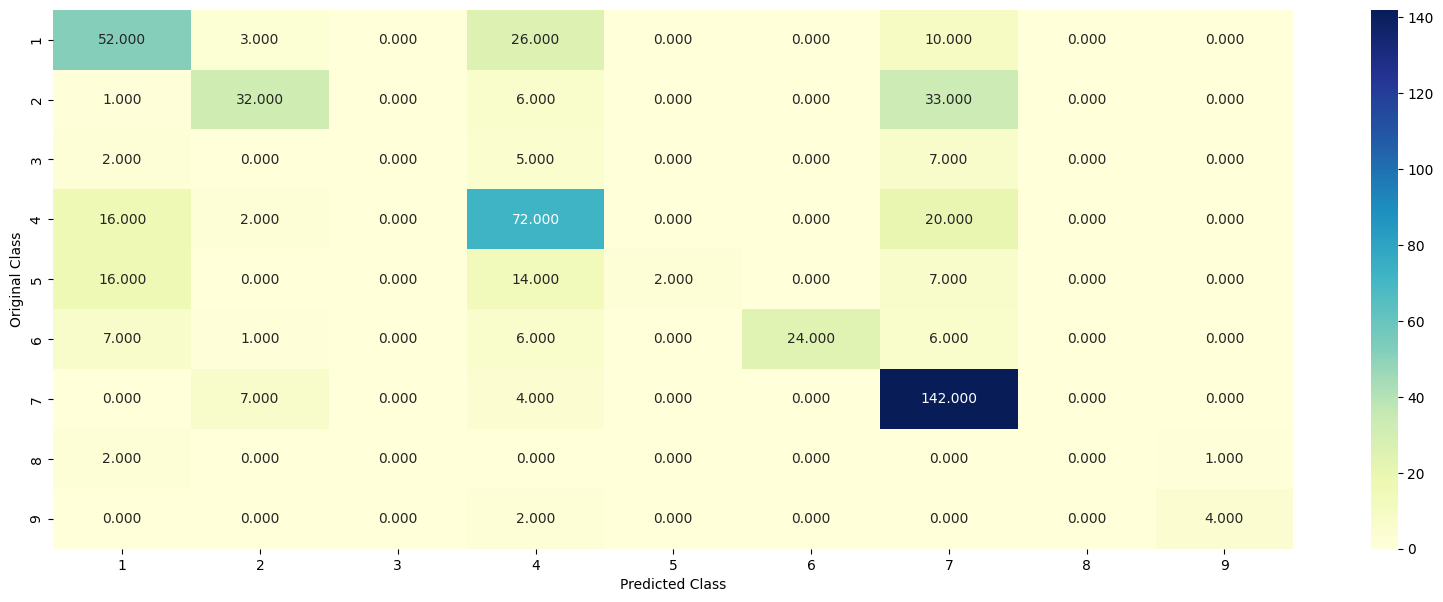

-------------------- Precision matrix (Columm Sum=1) --------------------


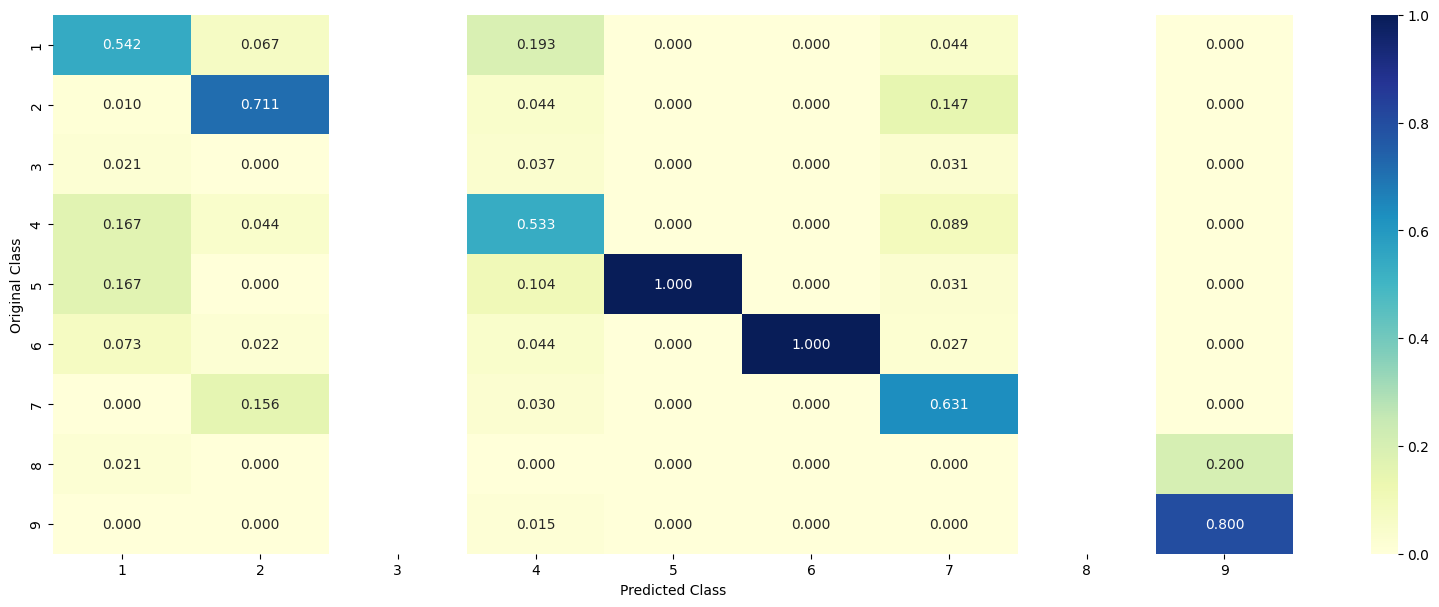

-------------------- Recall matrix (Row sum=1) --------------------


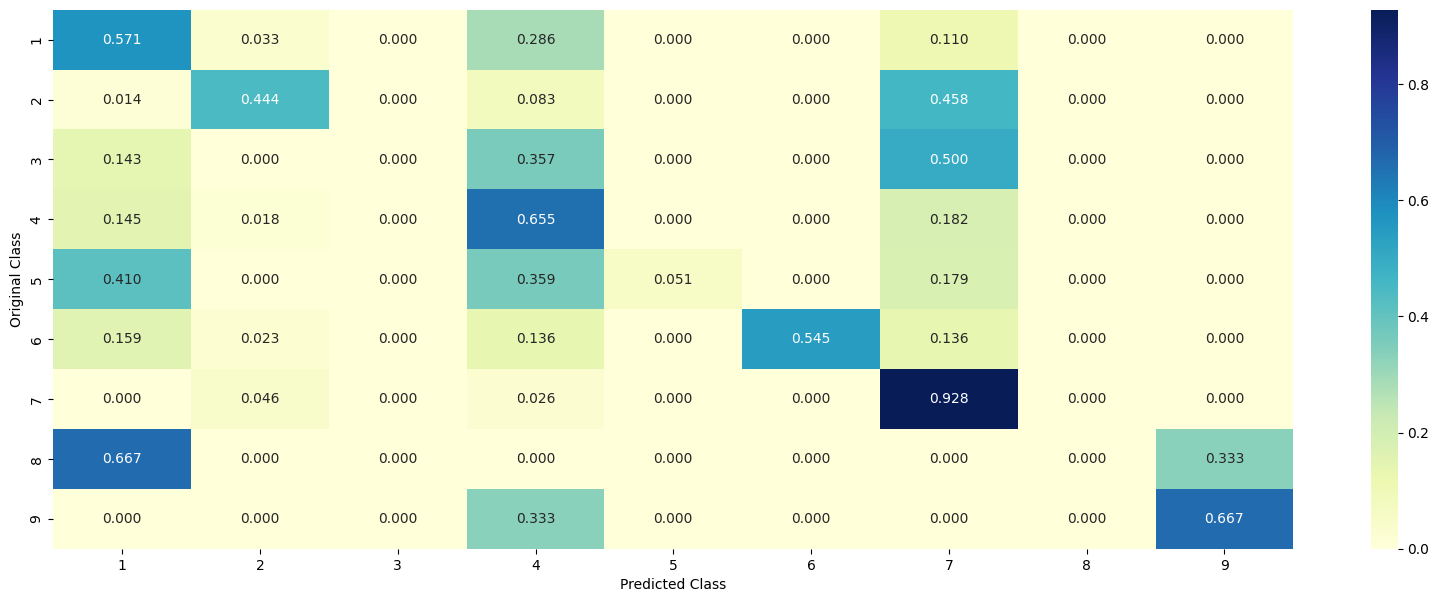

In [100]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [102]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0556 0.015  0.0142 0.8212 0.0374 0.0285 0.0195 0.0044 0.0041]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
6 Text feature [inhibitors] present in test data point [True]
9 Text feature [loss] present in test data point [True]
11 Text feature [missense] present in test data point [True]
13 Text feature [phosphorylation] present in test data point [True]
14 Text feature [suppressor] present in test data point [True]
16 Text feature [function] present in test data point [True]
17 Text feature [nonsense] present in test data point [True]
19 Text feature [frameshift] present in test data point [True]
20 Text feature [growth] present in test data point [True]
23 Text feature [downstream] present in test data point [True]
24 Text feature [stability] present in test data point [True]
26 Text feature [cells] present in test data point [True]
30 Text feature [mo

In [104]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0663 0.6288 0.0166 0.0601 0.0406 0.038  0.139  0.0056 0.0049]]
Actuall Class : 2
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
5 Text feature [constitutive] present in test data point [True]
6 Text feature [inhibitors] present in test data point [True]
8 Text feature [inhibitor] present in test data point [True]
11 Text feature [missense] present in test data point [True]
18 Text feature [therapeutic] present in test data point [True]
20 Text feature [growth] present in test data point [True]
22 Text feature [receptor] present in test data point [True]
26 Text feature [cells] present in test data point [True]
27 Text feature [trials] present in test data point [True]
29 Text feature [therapy] present in test data point [True]
30 Text feature [months]

for n_estimators = 10 and max depth =  2
Log Loss : 2.0056498544806374
for n_estimators = 10 and max depth =  3
Log Loss : 1.5935551956651892
for n_estimators = 10 and max depth =  5
Log Loss : 1.4547976643299452
for n_estimators = 10 and max depth =  10
Log Loss : 1.5275994397159434
for n_estimators = 50 and max depth =  2
Log Loss : 1.594690799463734
for n_estimators = 50 and max depth =  3
Log Loss : 1.3848063662044048
for n_estimators = 50 and max depth =  5
Log Loss : 1.3501337790413668
for n_estimators = 50 and max depth =  10
Log Loss : 1.6100270784956043
for n_estimators = 100 and max depth =  2
Log Loss : 1.4926962715543997
for n_estimators = 100 and max depth =  3
Log Loss : 1.3765999770056394
for n_estimators = 100 and max depth =  5
Log Loss : 1.2818259534831637
for n_estimators = 100 and max depth =  10
Log Loss : 1.6123542321579578
for n_estimators = 200 and max depth =  2
Log Loss : 1.4874178150905082
for n_estimators = 200 and max depth =  3
Log Loss : 1.363342795072502

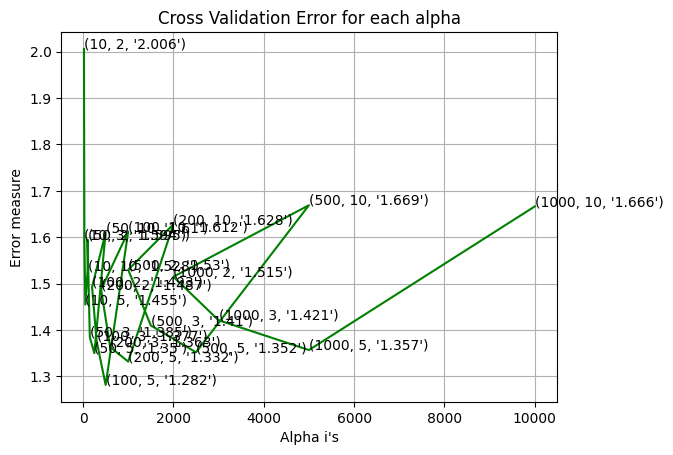

For values of best alpha =  100 The train log loss is: 0.06955427369706765
For values of best alpha =  100 The cross validation log loss is: 1.2818259534831637
For values of best alpha =  100 The test log loss is: 1.2712456343217096


In [105]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2818259534831637
Number of mis-classified points : 0.4398496240601504
-------------------- Confusion matrix --------------------


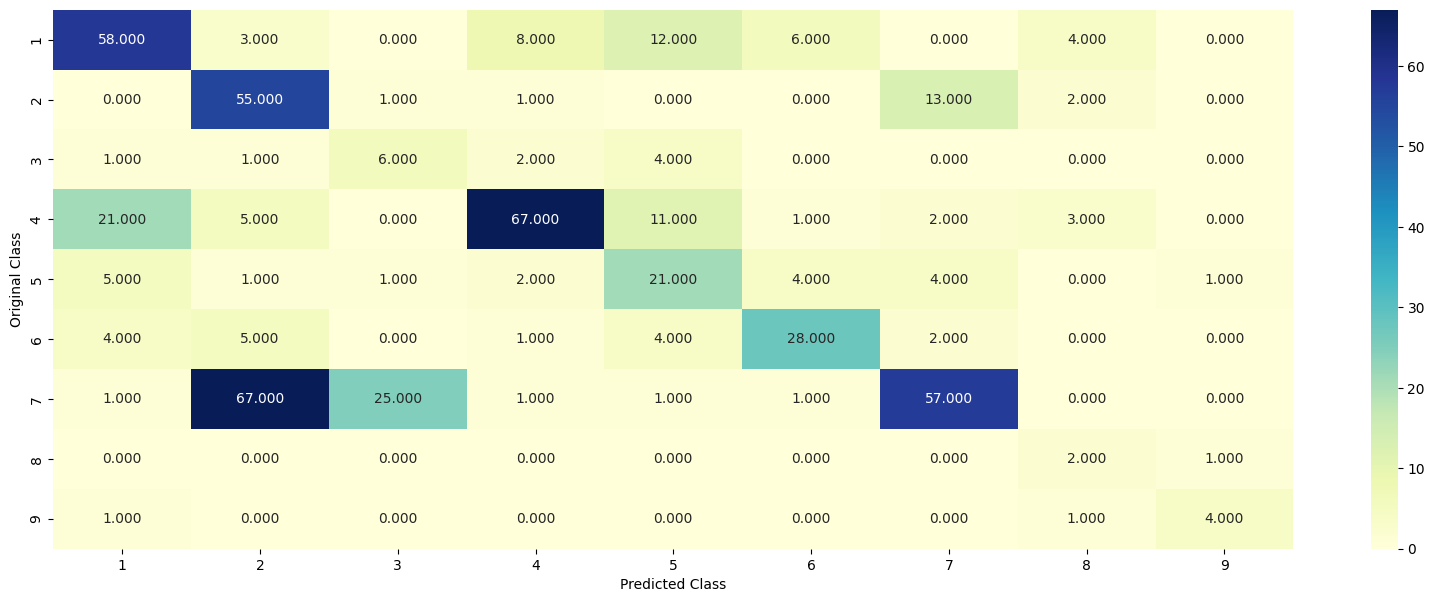

-------------------- Precision matrix (Columm Sum=1) --------------------


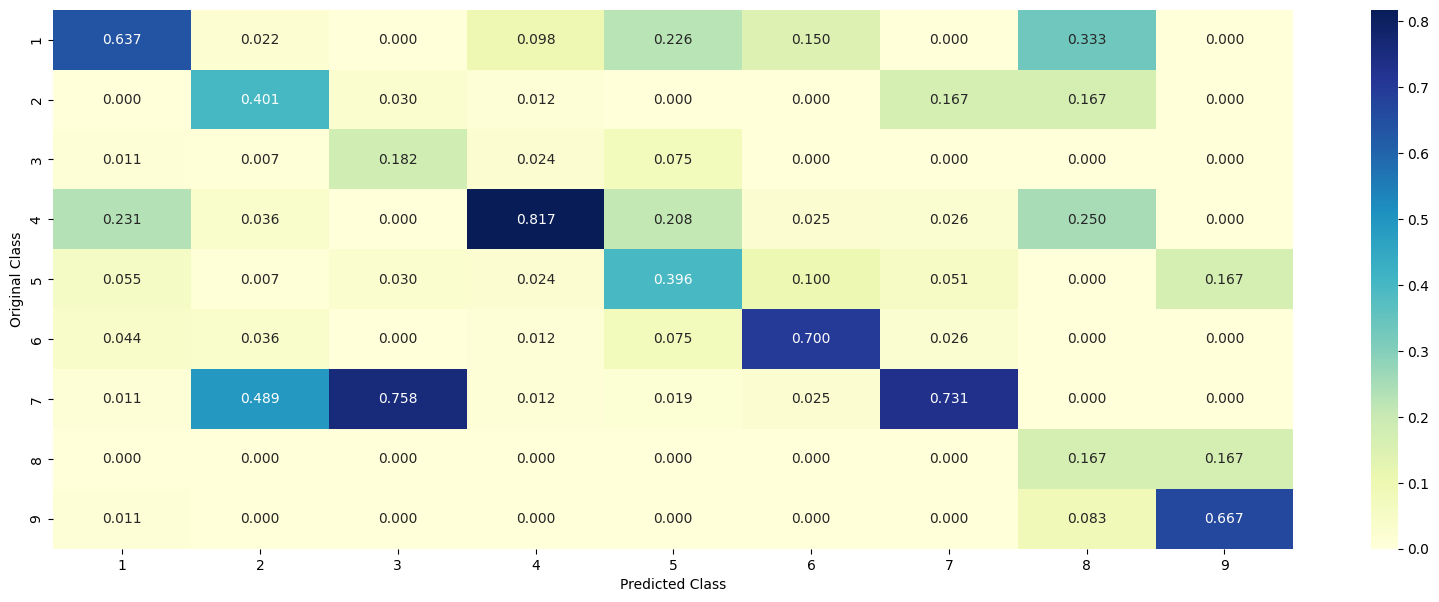

-------------------- Recall matrix (Row sum=1) --------------------


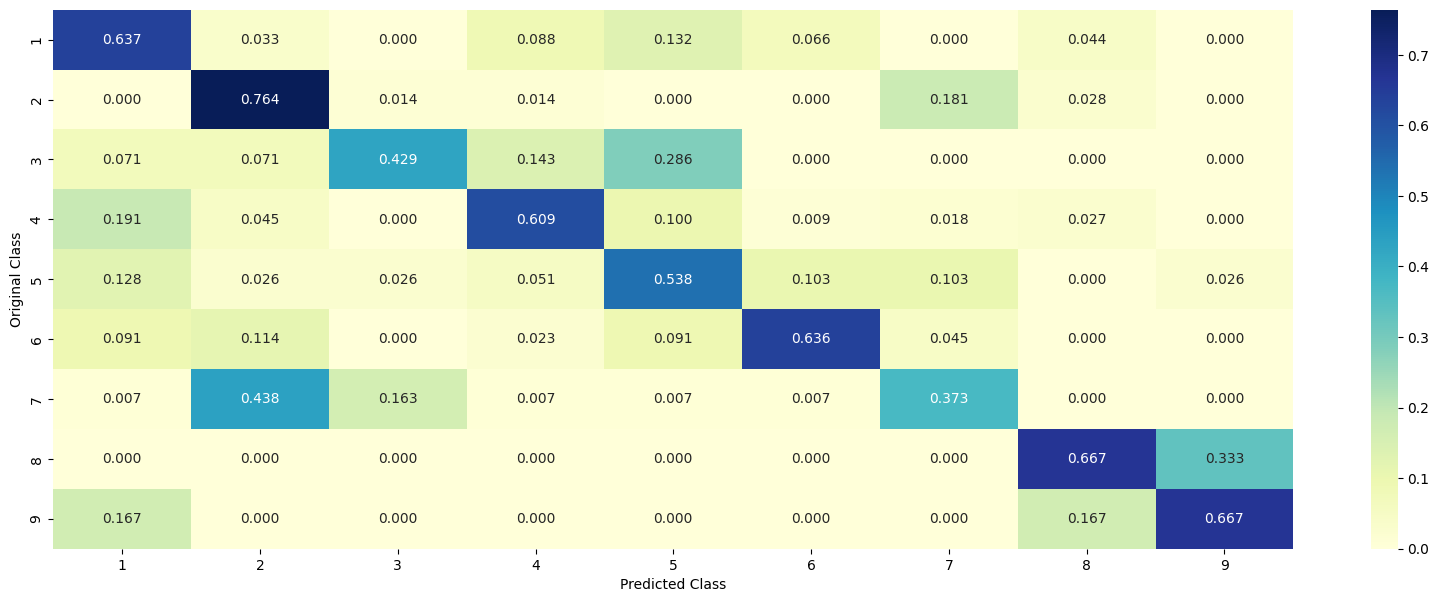

In [106]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [107]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.1199 0.0317 0.1816 0.5031 0.032  0.0448 0.0116 0.043  0.0322]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature


In [108]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0119 0.6477 0.1162 0.0135 0.0192 0.029  0.1221 0.0336 0.0069]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature


In [109]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.02
Support vector machines : Log Loss: 1.67
Naive Bayes : Log Loss: 1.25
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.721
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.313
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.133
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.411
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.776


Log loss (train) on the stacking classifier : 0.49643821052090364
Log loss (CV) on the stacking classifier : 1.1333550944805264
Log loss (test) on the stacking classifier : 1.1144956805688224
Number of missclassified point : 0.3473684210526316
-------------------- Confusion matrix --------------------


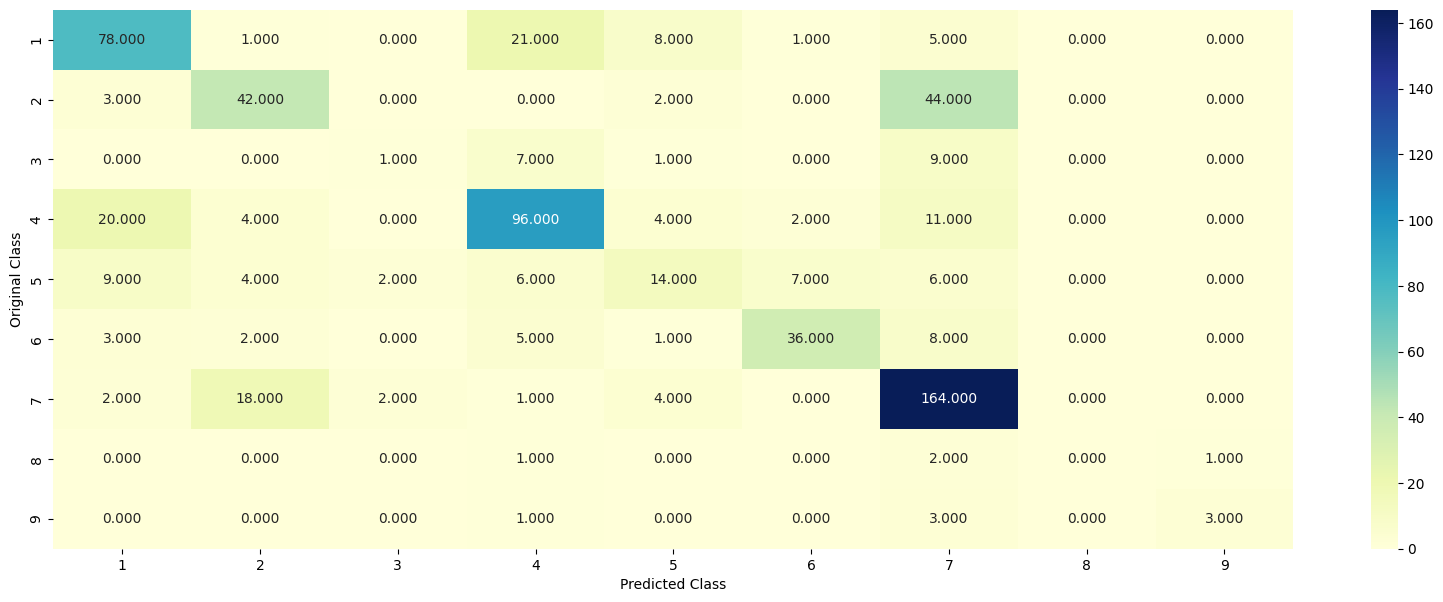

-------------------- Precision matrix (Columm Sum=1) --------------------


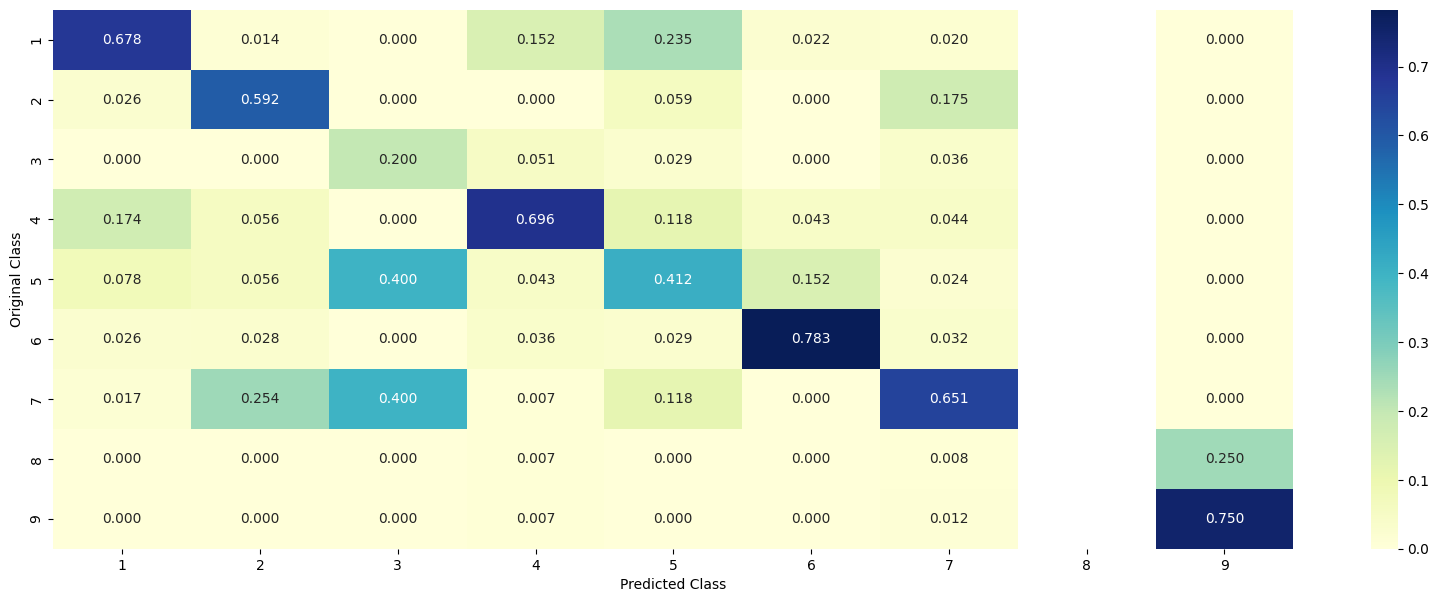

-------------------- Recall matrix (Row sum=1) --------------------


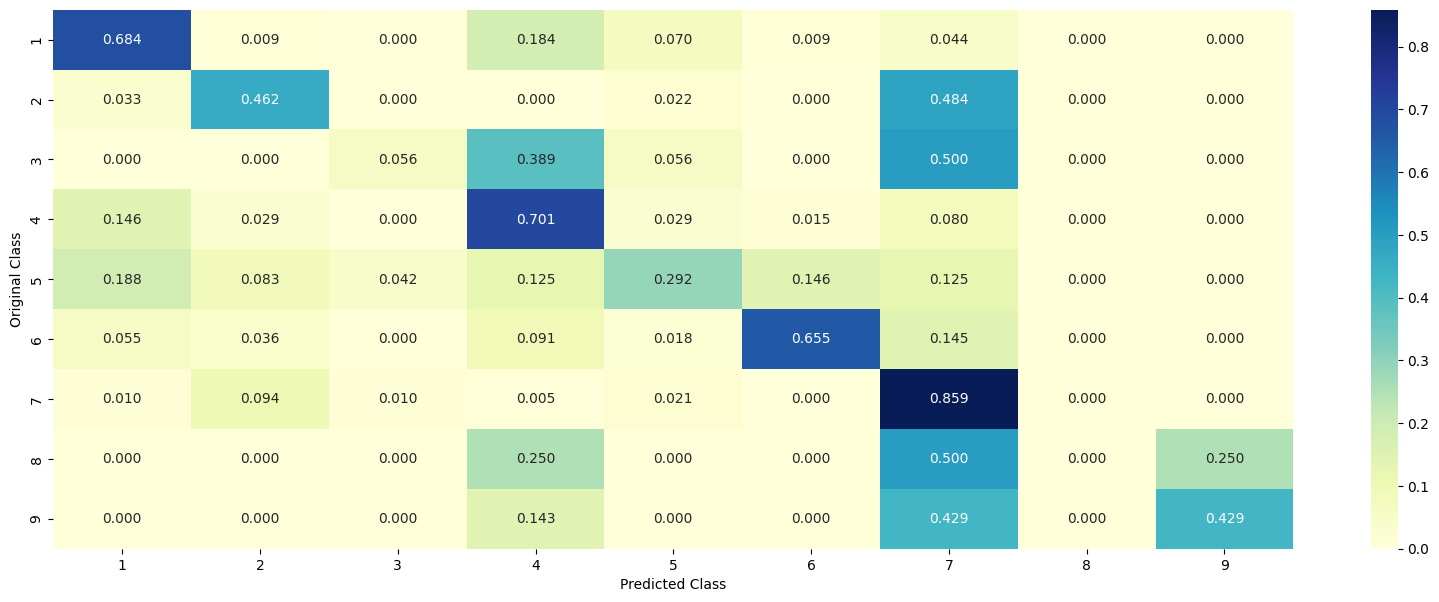

In [110]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

Log loss (train) on the VotingClassifier : 0.8565390981915931
Log loss (CV) on the VotingClassifier : 1.1531081577938311
Log loss (test) on the VotingClassifier : 1.1914342028635159
Number of missclassified point : 0.3533834586466165
-------------------- Confusion matrix --------------------


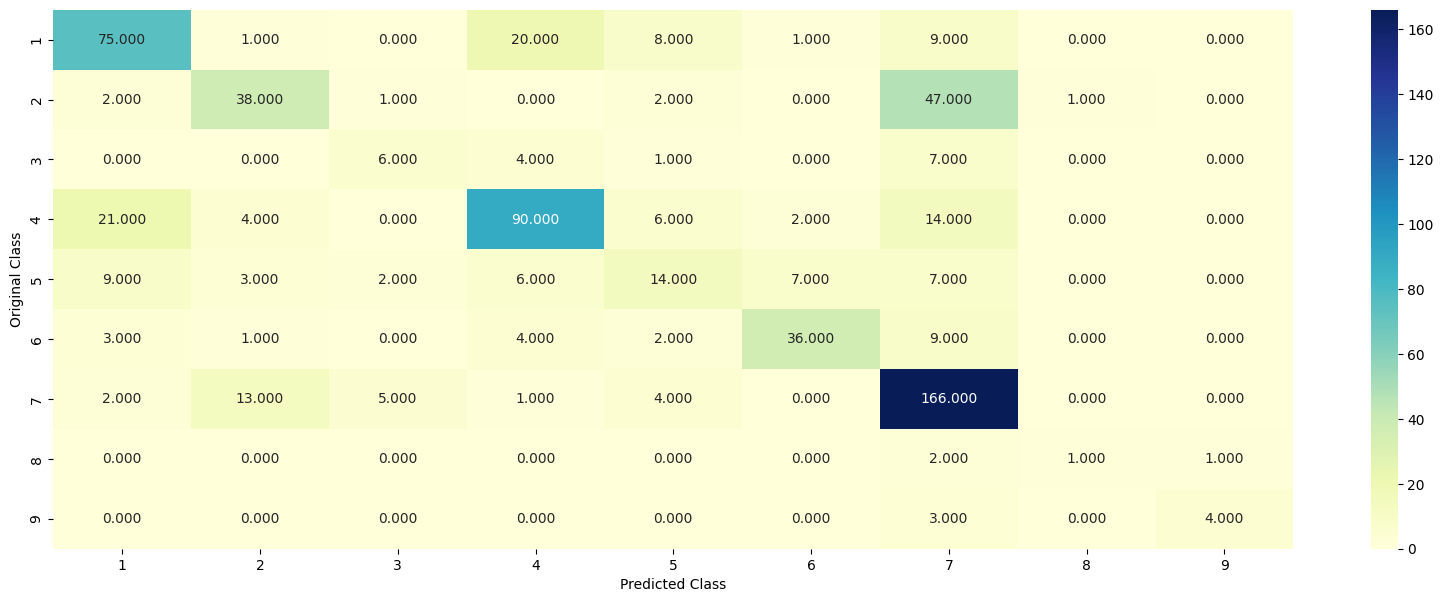

-------------------- Precision matrix (Columm Sum=1) --------------------


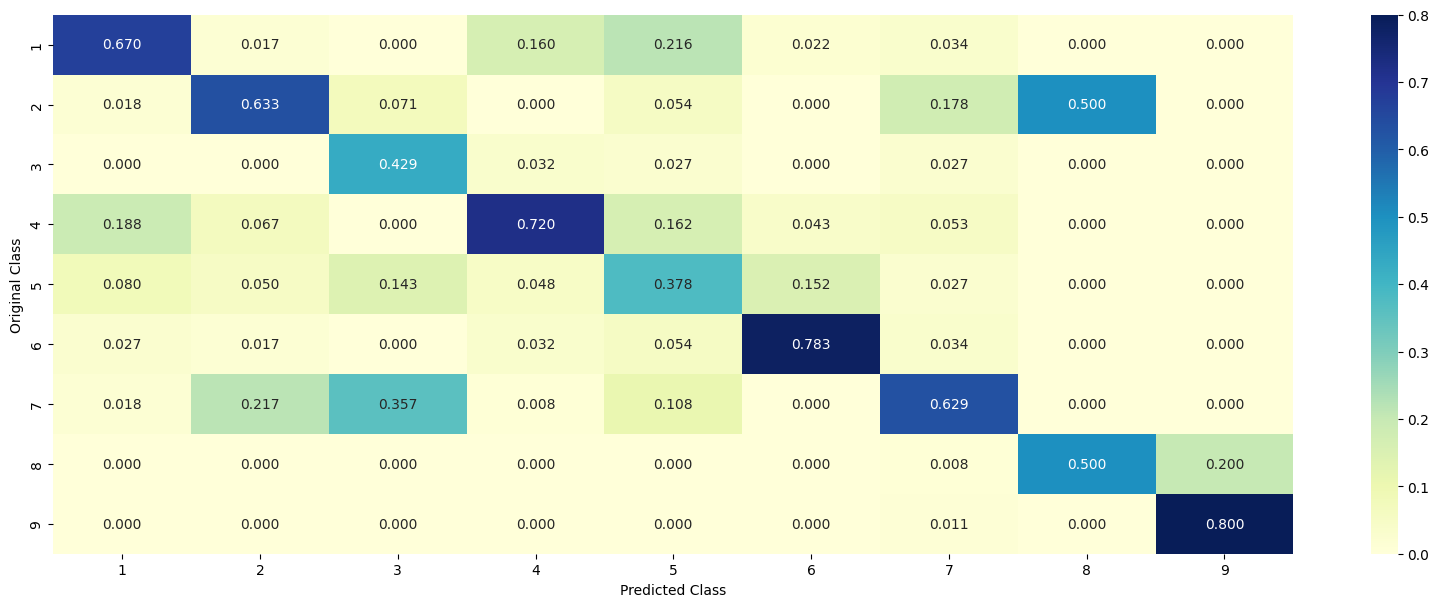

-------------------- Recall matrix (Row sum=1) --------------------


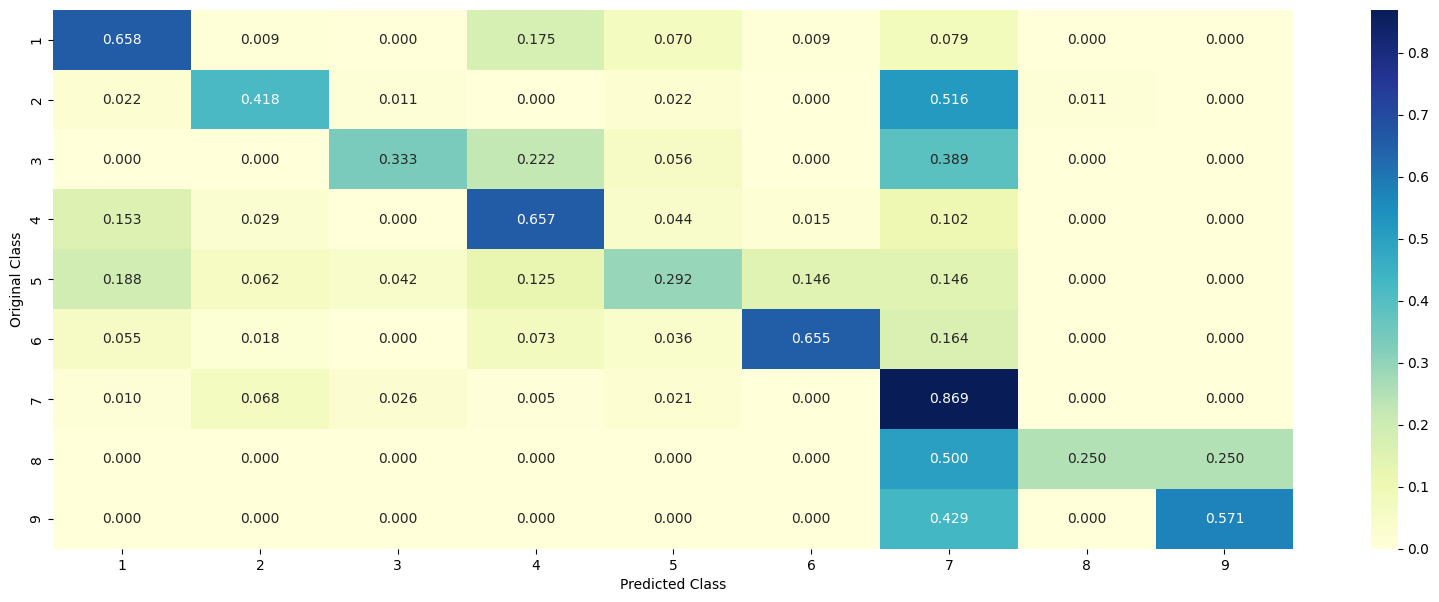

In [111]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))